<strong><center>**Predicción de sufrir un ataque cerebro vascular usando árboles de decisión**</center></strong>
***

# [Consigna](https://docs.google.com/document/d/1qvdD2FlI9xbU64m6cDjngZfINylKCJXYpyfxB9i7-Tc/edit?usp=sharing)**

* El objetivo de este trabajo práctico es analizar las particularidades de la utilización de algoritmos para la generación de árboles de decisión por medio de su aplicación en casos casi reales. El mismo pretende fijar conceptos estudiados en la teoría: sobreajuste y poda; tratamiento de datos faltantes; tolerancia al ruido; discretización de atributos numéricos. El material básico para la elaboración del presente trabajo se encuentra en las teóricas y prácticas presentadas hasta el momento y en las próximas clases y en la bibliografía indicada (por ej. libro de Mitchell). Podrá utilizarse cualquier otra fuente siempre que esté correctamente referenciada. 

* El presente trabajo será grupal. El grupo deberá estar compuesto por exactamente tres integrantes. Preferentemente uno de ellos debe saber programar. Se podrán evaluar contenidos del Trabajo Práctico durante el parcial posterior a la entrega del TP. Todos los integrantes deben tener conocimiento del desarrollo del TP.
* La fecha límite de entrega es el 30 de mayo a las 23:59 hs.

Para el desarrollo del trabajo se utilizará un conjunto de datos que proveerá la cátedra (healthcare-dataset-stroke-data.csv) con el objetivo de predecir qué paciente va a sufrir un accidente cerebrovascular. Para resolver este problema se utilizarán árboles de decisión. 

* Se deberá elaborar un informe preferentemente en LaTeX y entregarlo en formato .pdf. La entrega deberá estar acompañada de la Jupyter Notebook en Python utilizada para generar los resultados. El documento a entregar debe cumplir con los siguientes requisitos: 

    * Debe tener **no más que cuatro hojas**, con fuente tamaño 10 e interlineado simple. 
    * La bibliografía no cuenta en la cantidad de hojas.
    * Una carátula en donde figuren universidad, nombre de maestría, materia, número de grupo, nombres de los integrantes del grupo, número de TP, año de cursada, etc. La carátula no cuenta en la cantidad de hojas. 
    * Un resumen (del estilo de un artículo científico de no más de 200 palabras)
    * Una introducción en donde, entre otros, conste el objetivo del trabajo y una explicación de cómo está organizado el resto del documento.
    * Una sección de datos, en donde se describan los datos utilizados y sus particularidades
    * Una sección de metodología, en donde se describan las metodologías utilizadas (sobre datos y sobre algoritmos)
    * Una sección resultados, que incluya los resultados y su análisis
    * Una sección de conclusiones. Por tratarse de un trabajo de investigación netamente práctico, las conclusiones deben ser la resultante de la elaboración de las pruebas realizadas. La información obtenida de referencias externas puede y debe ser tomada como insumo, pero no como conclusión.

* Referencias bibliográficas (referenciadas a lo largo del trabajo)
* El informe se deberá publicar en el aula virtual de la materia por uno sólo de los integrantes del grupo.

Para realizar el informe se deberán considerarse y documentarse los siguientes puntos:
***



* Latex -> Exportar con Jupyter notebooks

## Librerías

Cargamos la librería a usar

In [1]:
# Instalación de librerías:
!pip install sweetviz
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import datetime
import IPython
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sweetviz as sv
import time
from matplotlib import pyplot
from numpy import mean
from numpy import std
from urllib.parse import urlparse

In [3]:
# Observación: Descomentar en caso de que quieran versionar los modelos y la búsqueda de hiperparámetros.
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.calibration import calibration_curve
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    roc_curve,
    make_scorer,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

### Utils

In [5]:
# Scorer que vamos a usar durante el notebook
scorer_f2 = make_scorer(fbeta_score, beta=2)

#### Setup mlflow

Mlflow es una herramienta para versionado de modelos. Permite registrar paramétros, métricas y guardar los modelos entrenados asociados a una iteración.

En caso de no ser necesario comentar estas lineas.

In [6]:
now = datetime.datetime.now()

In [7]:
mlflow.set_tracking_uri("http://mlflow_server:5000")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://mlflow_server:5000


In [8]:
mlflow.set_tracking_uri("http://mlflow_server:5000")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://mlflow_server:5000


In [9]:
# No hace falta el create, el set lo crea si no existe
experiment = mlflow.set_experiment(
    "AA.TP1.RandomizedSearchCV.{0}".format(now.strftime("%Y-%m-%d"))
)

## Leer dataset

In [10]:
# Versión con dataset en github
# df_strokes = pd.read_csv('https://raw.githubusercontent.com/blukitas/AA-2021/main/TPs/01.TP/healthcare-dataset-stroke-data.csv')
# df_original = pd.read_csv('https://raw.githubusercontent.com/blukitas/AA-2021/main/TPs/01.TP/healthcare-dataset-stroke-data.csv')
# Versión local
df_strokes = pd.read_csv("./healthcare-dataset-stroke-data.csv")
df_original = pd.read_csv("./healthcare-dataset-stroke-data.csv")

In [11]:
df_strokes.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

Desarrollo:
---

a) A partir de los datos entregados, describir los atributos realizando una breve explicación de qué representan y del tipo de variable (categórica, numérica u ordinal). En caso de que haya variables no numéricas, reportar los posibles valores que toman y cuán frecuentemente lo hacen.  

## Descriptivo de variables

In [12]:
analize_report = sv.analyze(df_strokes)
analize_report.show_html("analize.html", open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report analize.html was generated.



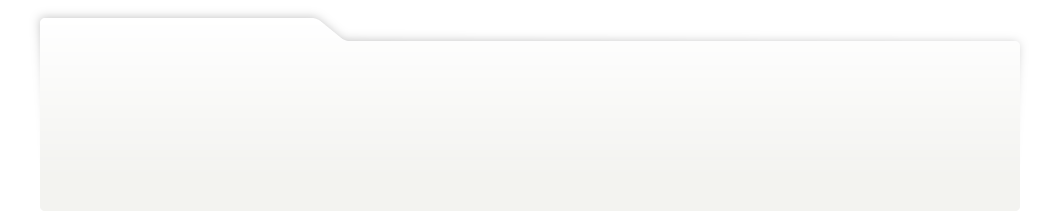
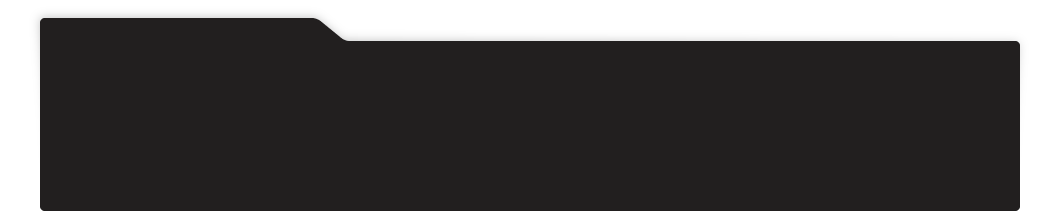
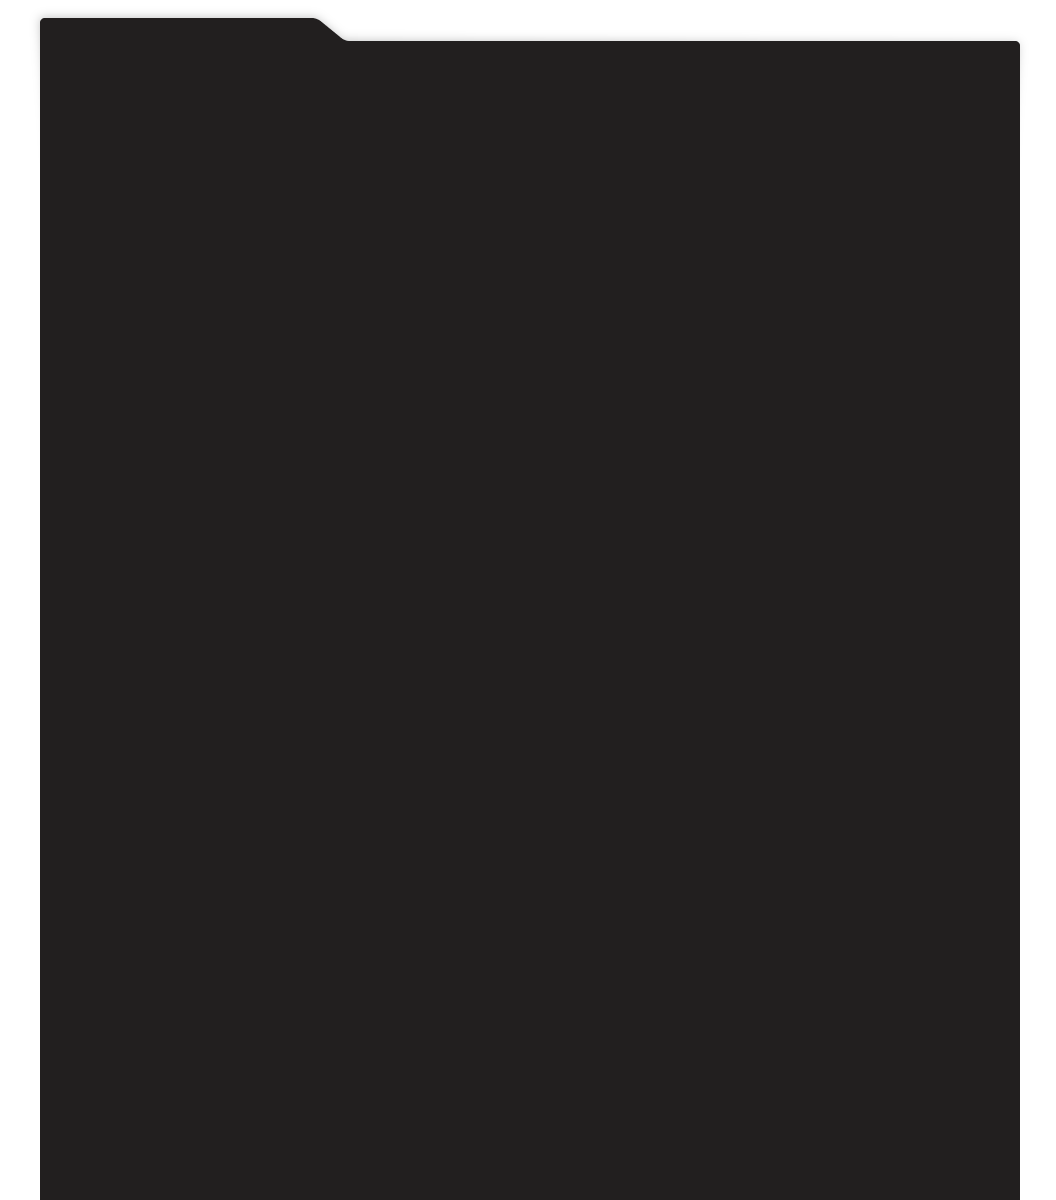
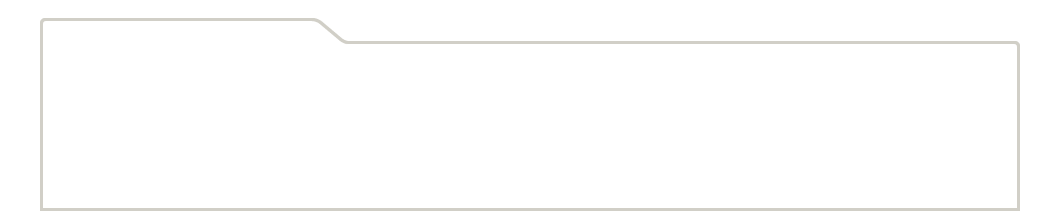
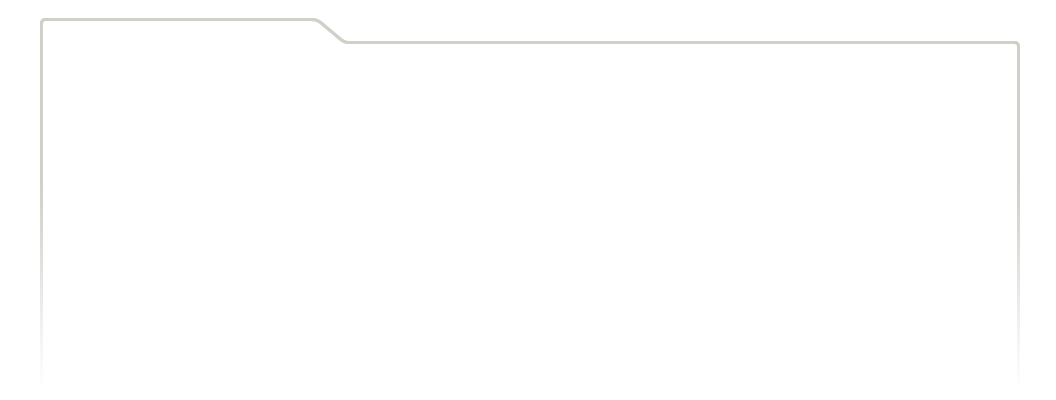
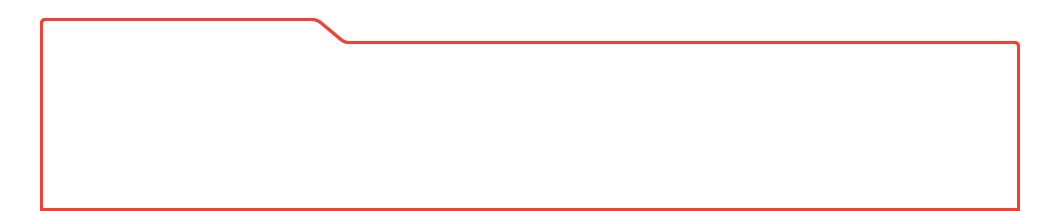
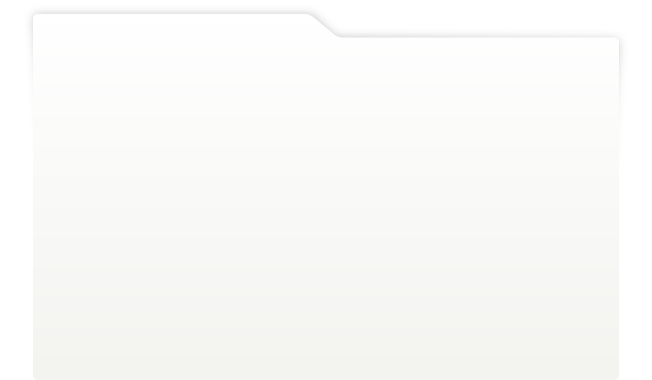
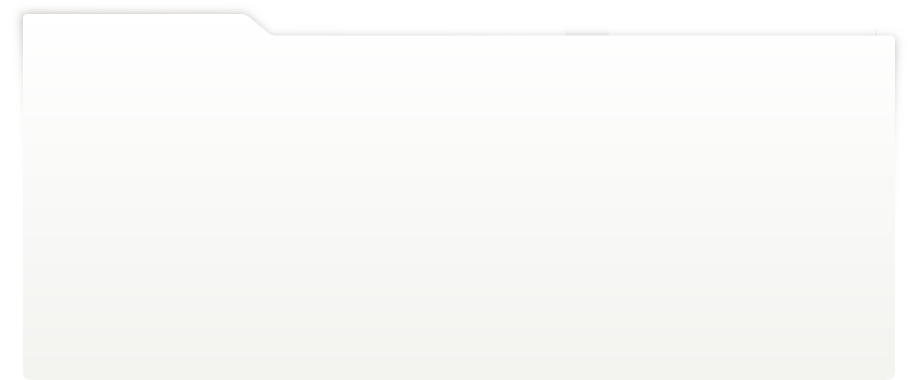
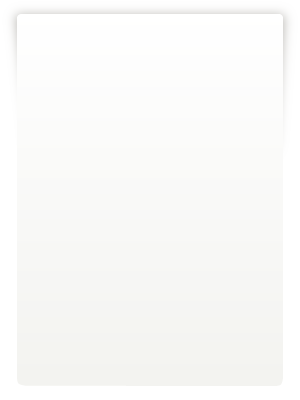
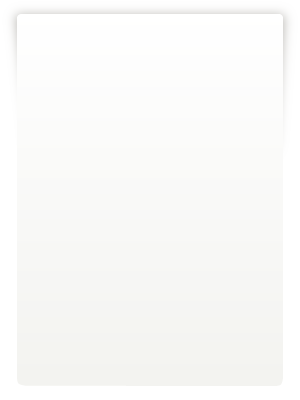
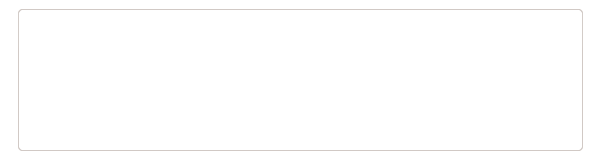
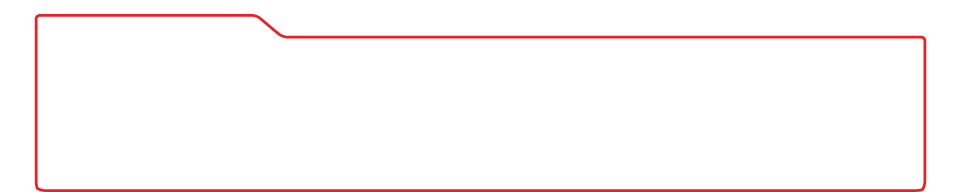
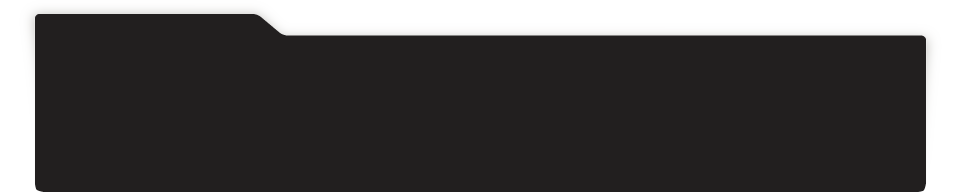
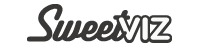
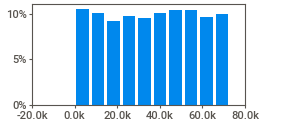
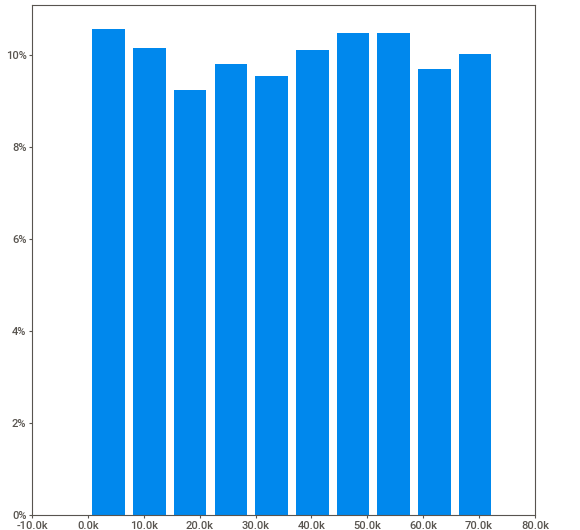
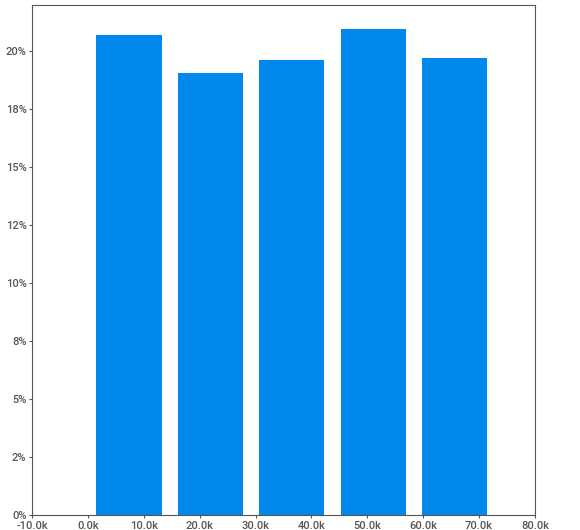
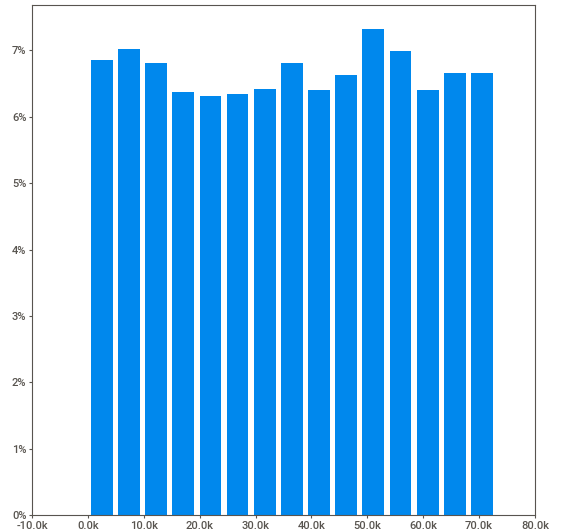
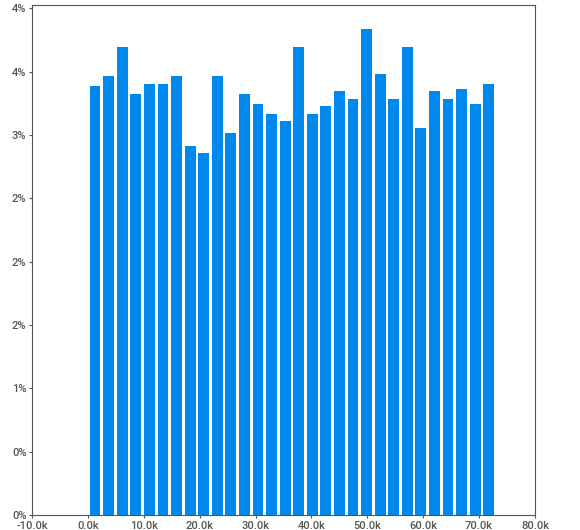
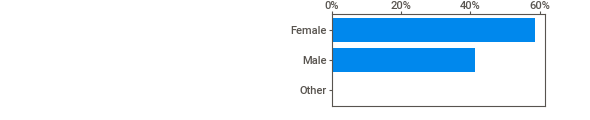
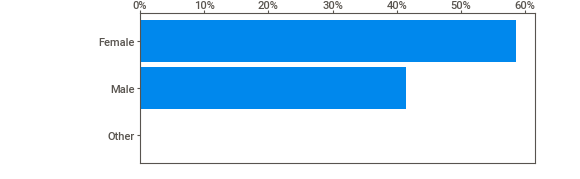
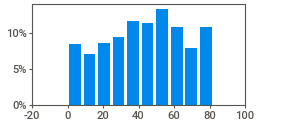
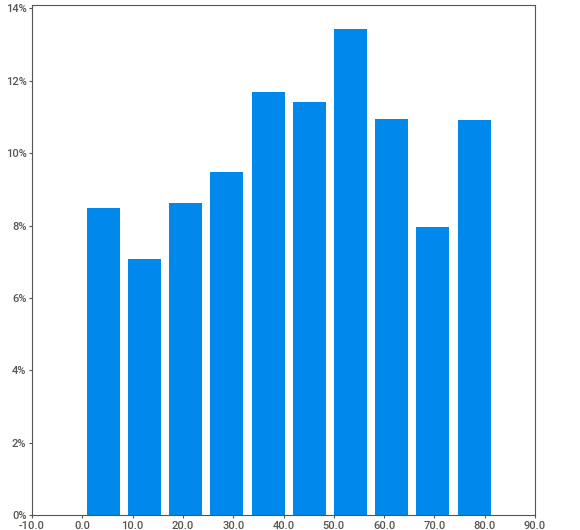
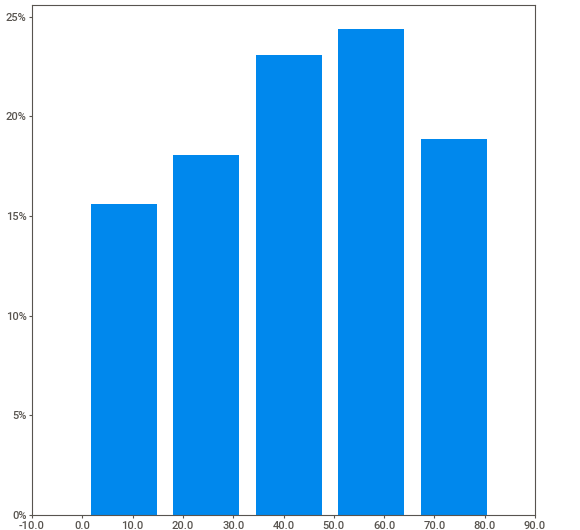
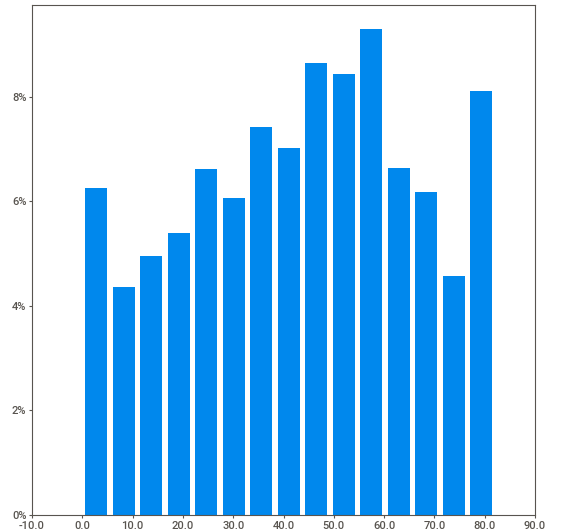
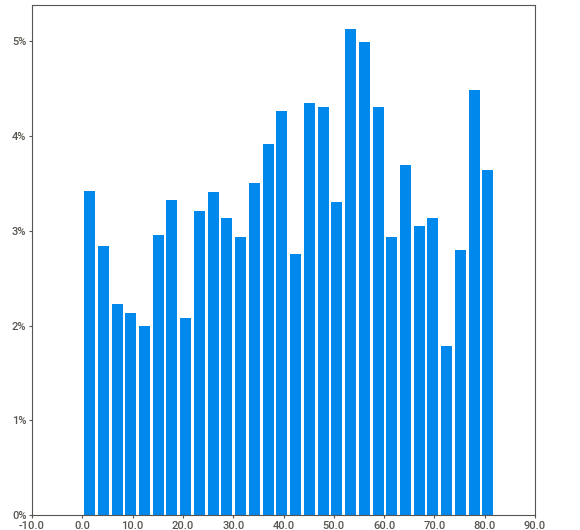
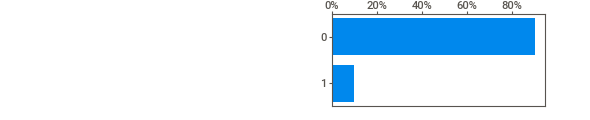
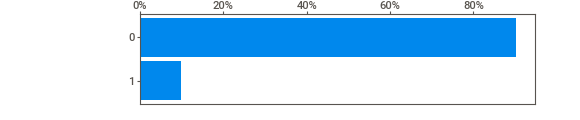
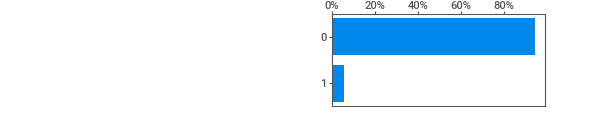
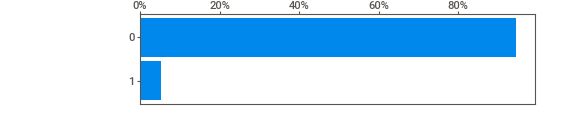
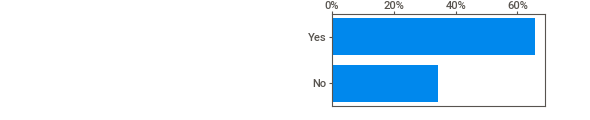
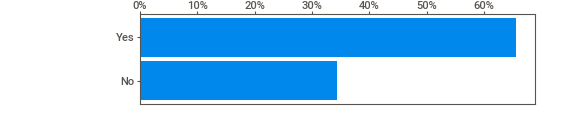
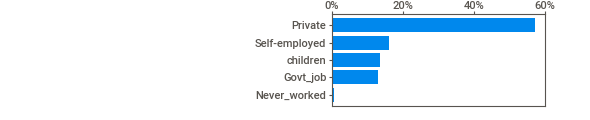
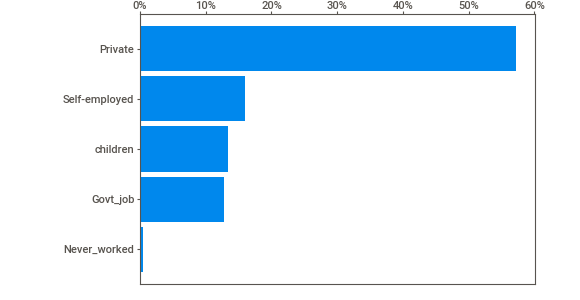
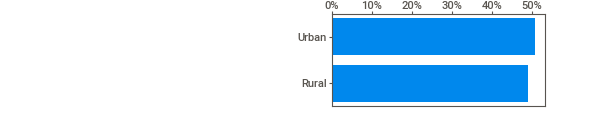
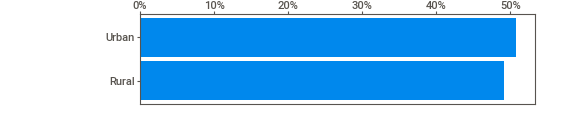
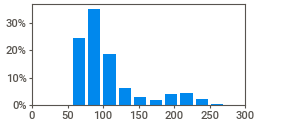
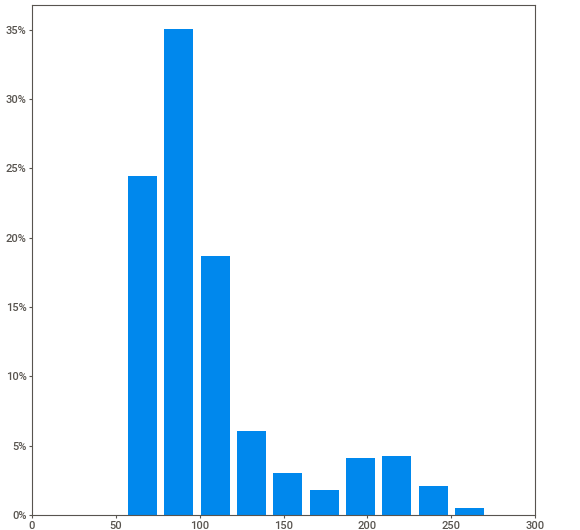
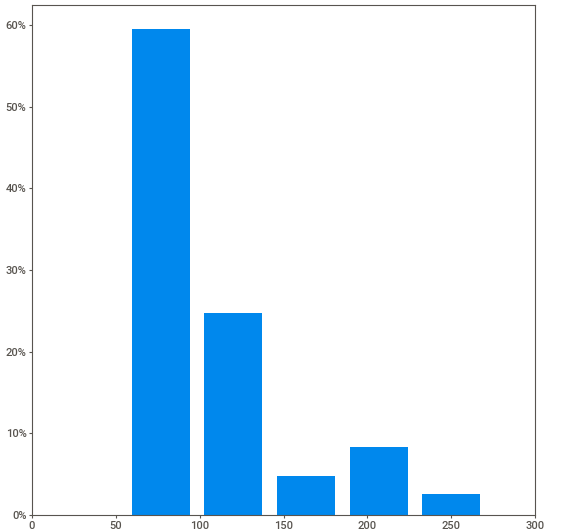
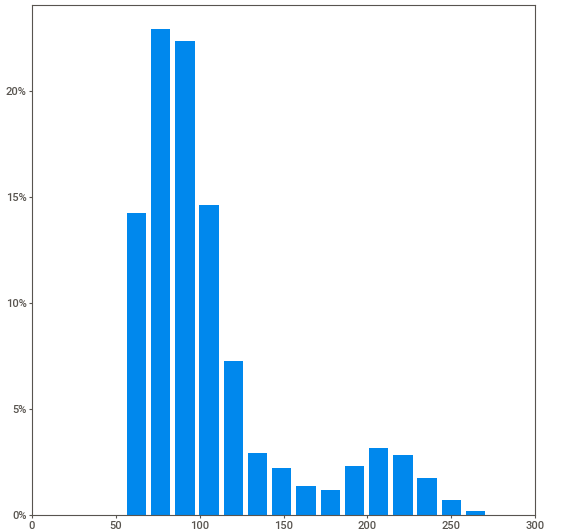
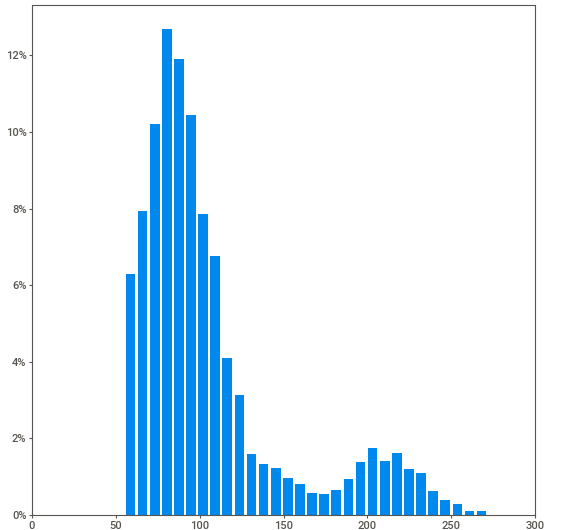
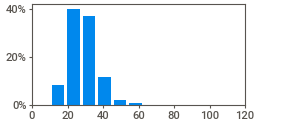
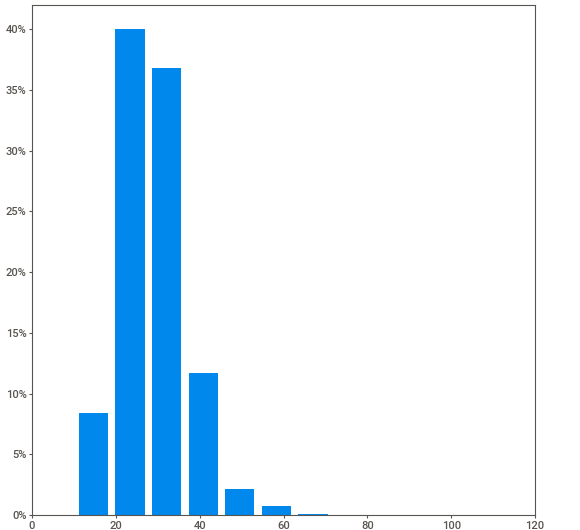
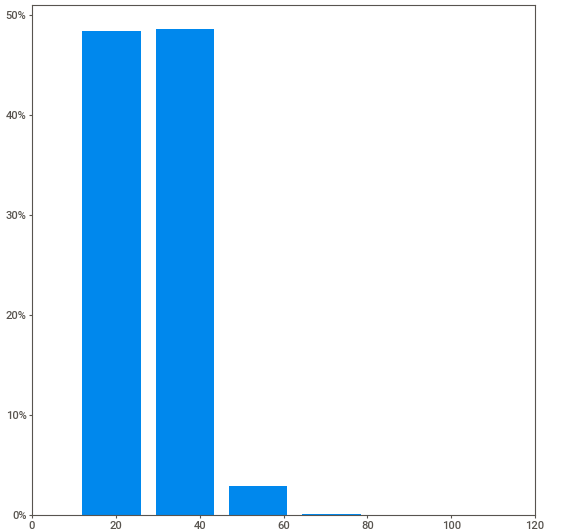
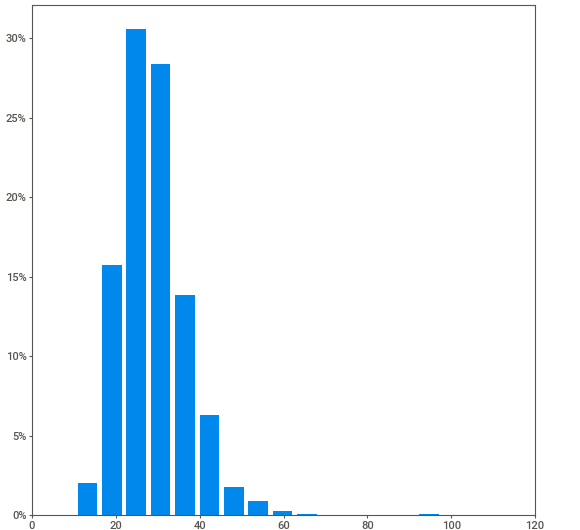
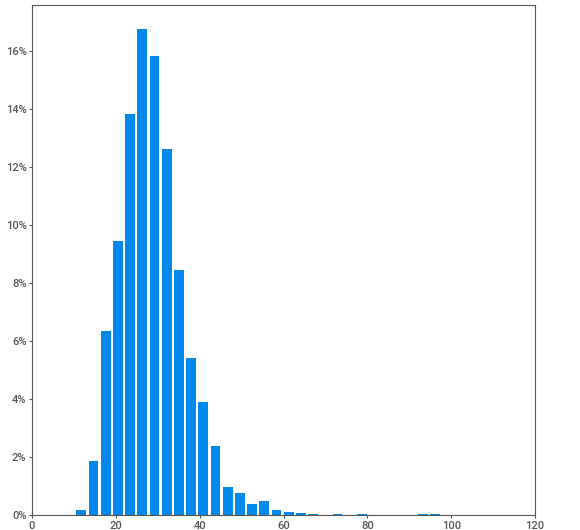
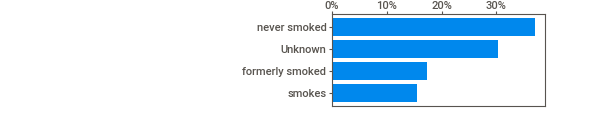
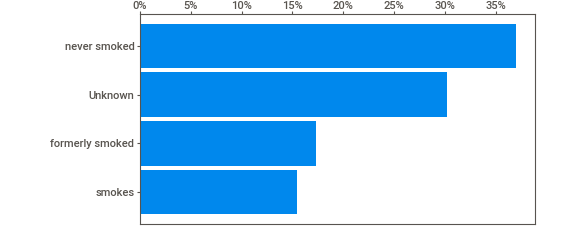
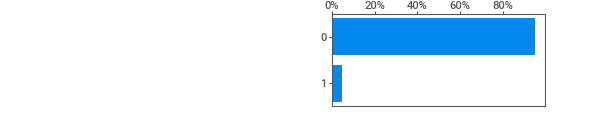
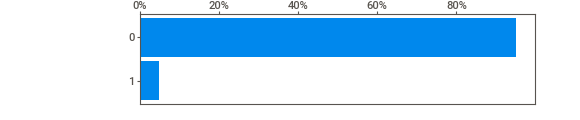
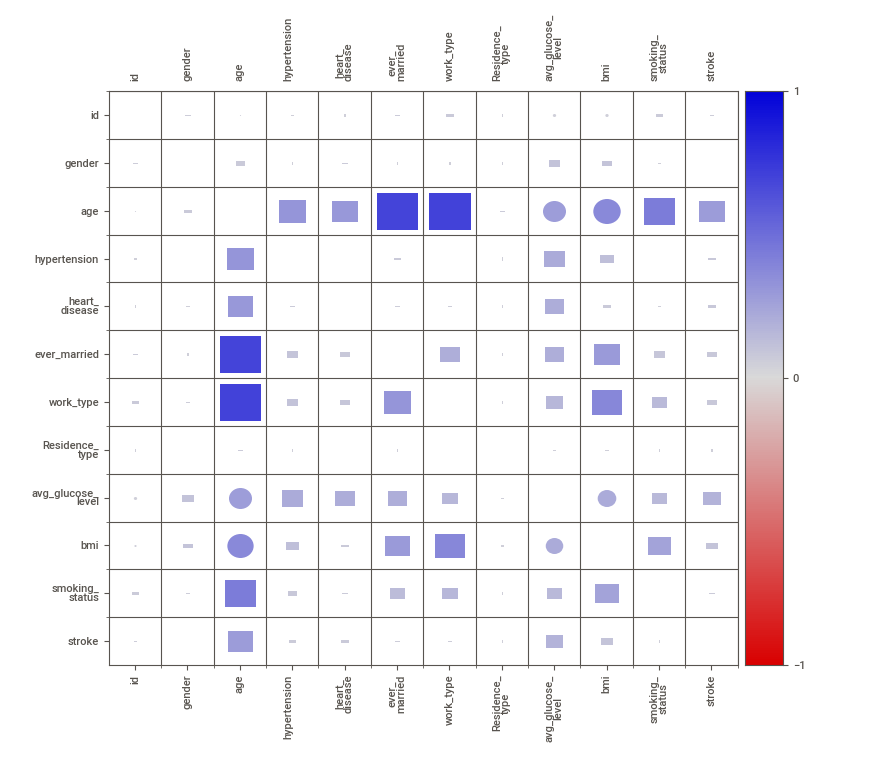
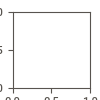

In [13]:
IPython.display.HTML("analize.html")

| Atributo      | Descripción | Tipo|
| ----------- | ----------- |----------- |
| id      | Identificador       | ? |
| gender   | Género        | Categórica |
| age   | Edad        |Numérica |
| hypertension   | Indicador de presencia de hipertensión        | Categórica |
| heart_disease   | Indicador de presencia de enfermedad cardíaca        | Categórica |
| ever_married   | Indica si el sujeto alguna vez estuvo casado         |Categórica |
| work_type   | Tipo de trabajo        |Categórica |
| Residence_type   | Tipo de residencia        | Categórica |
| avg_glucose_level   | Nivel promedio de la glucosa en sangre        | Numérica |
| bmi   | [Body Mass Index (Índice de masa corporal)](https://www.cdc.gov/healthyweight/assessing/bmi/index.html#:~:text=Body%20Mass%20Index%20(BMI)%20is,or%20health%20of%20an%20individual.)|Numérica |
| smoking_status   |  [Tipo de fumador o no❓❓](https://www.cdc.gov/nchs/nhis/tobacco/tobacco_glossary.htm)     |Categórica |
| stroke   | Indicador de si alguna vez ha sufrido algún accidente cerebrovascular        |Categórica |

### Edad

Análisis exploratorio de la edad. 

* Entender los valores menores a 1
* Valores atípicos de work_type y smoking_status para menores


In [14]:
df_strokes[df_strokes.work_type == "children"].sort_values("age", ascending=False)

id  gender    age  hypertension  heart_disease ever_married  \
3357  32717    Male  16.00             0              0           No   
1455  72132    Male  16.00             0              0           No   
4604  46691    Male  16.00             0              0           No   
921   32554  Female  16.00             0              0           No   
3719  49095  Female  16.00             0              0           No   
...     ...     ...    ...           ...            ...          ...   
4021   8247    Male   0.16             0              0           No   
3968  41500    Male   0.16             0              0           No   
3618  22877    Male   0.16             0              0           No   
3295  29955    Male   0.08             0              0           No   
1614  47350  Female   0.08             0              0           No   

     work_type Residence_type  avg_glucose_level   bmi smoking_status  stroke  
3357  children          Rural             106.11  22.4        Unknown       0  
1455  children          Urban             102.30  21.9        Unknown       0  
4604  children          Urban             140.10  38.7   never smoked       0  
921   children          Rural             109.02  19.8        Unknown       0  
3719  children          Urban              64.51  21.2        Unknown       0  
...        ...            ...                ...   ...            ...     ...  
4021  children          Urban             109.52  13.9        Unknown       0  
3968  children          Rural              69.79  13.0        Unknown       0  
3618  children          Urban             114.71  17.4        Unknown       0  
3295  children          Rural              70.33  16.9        Unknown       0  
1614  children          Urban             139.67  14.1        Unknown       0  

[687 rows x 12 columns]

In [15]:
df_strokes[df_strokes.age < 1].work_type.value_counts()

children    43
Name: work_type, dtype: int64

In [16]:
df_strokes[
    np.logical_and((df_strokes.smoking_status == "Unknown"), (df_strokes.age < 1))
].work_type.value_counts()

children    43
Name: work_type, dtype: int64

In [17]:
df_strokes[df_strokes.age < 1].head(20)

id  gender   age  hypertension  heart_disease ever_married work_type  \
363    7559  Female  0.64             0              0           No  children   
376   22706  Female  0.88             0              0           No  children   
564   61511  Female  0.32             0              0           No  children   
982   54747    Male  0.88             0              0           No  children   
996   53279    Male  0.24             0              0           No  children   
1093  66772  Female  0.32             0              0           No  children   
1206  68908  Female  0.72             0              0           No  children   
1317  30084    Male  0.80             0              0           No  children   
1600  40544    Male  0.40             0              0           No  children   
1614  47350  Female  0.08             0              0           No  children   
1808  53126  Female  0.64             0              0           No  children   
1975   6596    Male  0.56             0              0           No  children   
1999  42500    Male  0.24             0              0           No  children   
2008  67099    Male  0.56             0              0           No  children   
2012  34261    Male  0.64             0              0           No  children   
2030  38920    Male  0.48             0              0           No  children   
2358   1275    Male  0.88             0              0           No  children   
2481  20257    Male  0.88             0              0           No  children   
2490  48406    Male  0.88             0              0           No  children   
2579  68382    Male  0.32             0              0           No  children   

     Residence_type  avg_glucose_level   bmi smoking_status  stroke  
363           Urban              83.82  24.9        Unknown       0  
376           Rural              88.11  15.5        Unknown       0  
564           Rural              73.71  16.2        Unknown       0  
982           Rural             157.57  19.2        Unknown       0  
996           Rural             118.87  16.3        Unknown       0  
1093          Rural              55.86  16.0        Unknown       0  
1206          Urban              66.36  23.0        Unknown       0  
1317          Rural              98.67  17.5        Unknown       0  
1600          Urban             109.56  14.3        Unknown       0  
1614          Urban             139.67  14.1        Unknown       0  
1808          Urban              62.27  17.3        Unknown       0  
1975          Rural             111.77  21.1        Unknown       0  
1999          Rural             146.97  18.5        Unknown       0  
2008          Rural              57.02  20.7        Unknown       0  
2012          Rural              86.74  16.2        Unknown       0  
2030          Urban              73.02   NaN        Unknown       0  
2358          Urban             112.19  18.9        Unknown       0  
2481          Urban              90.62  22.4        Unknown       0  
2490          Urban              85.38  23.4        Unknown       0  
2579          Urban             127.78  20.8        Unknown       0

In [18]:
df_strokes[(df_strokes.work_type == "children")].smoking_status.value_counts()

Unknown            618
never smoked        54
formerly smoked     13
smokes               2
Name: smoking_status, dtype: int64

In [19]:
df_strokes[
    np.logical_and(
        (df_strokes.work_type == "children"), (df_strokes.smoking_status == "smokes")
    )
]

id  gender   age  hypertension  heart_disease ever_married work_type  \
1512   4833  Female  12.0             0              0           No  children   
2013  64128    Male  10.0             0              0           No  children   

     Residence_type  avg_glucose_level   bmi smoking_status  stroke  
1512          Rural             207.45  25.4         smokes       0  
2013          Urban              63.08  20.5         smokes       0

In [20]:
df_strokes[
    np.logical_and((df_strokes.work_type == "children"), (df_strokes.age < 10))
].smoking_status.value_counts()

Unknown    470
Name: smoking_status, dtype: int64

In [21]:
df_strokes[df_strokes.age < 10].smoking_status.value_counts()

Unknown    472
Name: smoking_status, dtype: int64

In [22]:
# Fix: unknow como nunca fumaron
df_strokes.loc[(df_strokes.age < 10), "smoking_status"] = "never smoked"

In [23]:
df_strokes[df_strokes.age < 12].work_type.value_counts()

children         541
Private            1
Self-employed      1
Name: work_type, dtype: int64

In [24]:
df_strokes[np.logical_and((df_strokes.work_type == "Private"), (df_strokes.age < 12))]

id  gender  age  hypertension  heart_disease ever_married work_type  \
251  16523  Female  8.0             0              0           No   Private   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
251          Urban             110.89  17.6   never smoked       0

In [25]:
df_strokes[
    np.logical_and((df_strokes.work_type == "Self-employed"), (df_strokes.age < 12))
]

id gender  age  hypertension  heart_disease ever_married  \
410  54975   Male  7.0             0              0           No   

         work_type Residence_type  avg_glucose_level   bmi smoking_status  \
410  Self-employed          Rural              64.06  18.9   never smoked   

     stroke  
410       0

In [26]:
df_strokes[
    np.logical_and((df_strokes.work_type == "Never_worked"), (df_strokes.age < 12))
]

Empty DataFrame
Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []

In [27]:
# Fix: Mal taggeado never_work para children
df_strokes.loc[
    np.logical_and((df_strokes.work_type == "Never_worked"), (df_strokes.age < 14)),
    "work_type",
] = "children"

In [28]:
# Fix: < 10, worktype = 'children'
df_strokes.loc[(df_strokes.age < 10), "work_type"] = "children"

### Categóricos

In [29]:
# Variables identificadas como categóricas
# Descripción y transformación de object a categóricas

for i in [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "stroke",
]:
    print(f"Variable: {i}")
    df_strokes[i].value_counts()
    print(f"Cantidad de valores que toma: {df_strokes[i].value_counts().count()}")
    df_strokes[i] = df_strokes[i].astype("category")

Variable: gender
Cantidad de valores que toma: 3
Variable: hypertension
Cantidad de valores que toma: 2
Variable: heart_disease
Cantidad de valores que toma: 2
Variable: ever_married
Cantidad de valores que toma: 2
Variable: work_type
Cantidad de valores que toma: 5
Variable: Residence_type
Cantidad de valores que toma: 2
Variable: smoking_status
Cantidad de valores que toma: 4
Variable: stroke
Cantidad de valores que toma: 2


In [30]:
# Visualizar la distribución de valores para una variable (En porcentaje)
df_strokes["gender"].value_counts(normalize=True)

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

In [31]:
# Visualización de dtypes corregidos
df_strokes.dtypes

id                      int64
gender               category
age                   float64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke               category
dtype: object

In [32]:
round (df_strokes.describe(exclude = ['float', 'int64']),2)

gender  hypertension  heart_disease ever_married work_type  \
count     5110          5110           5110         5110      5110   
unique       3             2              2            2         5   
top     Female             0              0          Yes   Private   
freq      2994          4612           4834         3353      2924   

       Residence_type smoking_status  stroke  
count            5110           5110    5110  
unique              2              4       2  
top             Urban   never smoked       0  
freq             2596           2364    4861

## Discretización 

In [33]:
# Discretización - Binning de variables numéricas
df_strokes["bmi_discretizada"] = pd.cut(
    df_strokes["bmi"],
    bins=[0, 19, 25, 30, 10000],
    labels=["bajo_peso", "ideal", "sobrepeso", "obesidad"],
)
df_strokes["age_discretizada"] = pd.cut(
    df_strokes["age"],
    bins=[0, 13, 18, 45, 60, 200],
    labels=["niño", "adolescente", "adulto", "adulto_mayor", "senectud"],
)
# Senectud podría ser tercera_edad
df_strokes["glucose_discretizada"] = pd.cut(
    df_strokes["avg_glucose_level"],
    bins=[0, 90, 160, 230, 500],
    labels=["bajo", "normal", "alto", "muy_alto"],
)

## Encoding y categoricas

In [34]:
# Encodings
# Ref: https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

# Para las variables True/False codificar usando el valor del categórico
df_strokes["ever_married_cat"] = df_strokes["ever_married"].cat.codes
df_strokes["resident_type_urban"] = df_strokes["Residence_type"].cat.codes

# Para las variables con múltiples valores usando one-hot-encoding
# Instancia de one-hot-encoder
enc = OneHotEncoder(handle_unknown="ignore")


enc_df = pd.DataFrame(
    enc.fit_transform(df_strokes[["gender"]]).toarray(),
    columns=enc.get_feature_names(["gender"]),
)

df_strokes = df_strokes.join(enc_df)
enc_df = pd.DataFrame(
    enc.fit_transform(df_strokes[["work_type"]]).toarray(),
    columns=enc.get_feature_names(["work_type"]),
)

# Observación, como se nombró en una clase de consulta, pensamos en utilizar
#    label_encoding para esta variable, porque hay cierta ordinalidad en los valores.
#    Pero lo cierto es que no tenemos dimensión de la magnitud que separa los valores
#    y usar label_encoding puede ser darle un orden que 'deforma' el dataset.
df_strokes = df_strokes.join(enc_df)
enc_df = pd.DataFrame(
    enc.fit_transform(df_strokes[["smoking_status"]]).toarray(),
    columns=enc.get_feature_names(["smoking_status"]),
)

# Merge con el df encodeado
df_strokes = df_strokes.join(enc_df)

In [35]:
# Visualizacion de las columnas
df_strokes.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'bmi_discretizada', 'age_discretizada',
       'glucose_discretizada', 'ever_married_cat', 'resident_type_urban',
       'gender_Female', 'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [36]:
# Renombrado de columnas resultantes en el one-hot-encoding que quedaron con espacios
df_strokes.rename(
    columns={
        "smoking_status_never smoked": "smoking_status_never_smoked",
        "smoking_status_formerly smoked": "smoking_status_formerly_smoked",
    },
    inplace=True,
)

In [37]:
# Visualización de variables con encoding y discretizadas

analize_report = sv.analyze(df_strokes)
analize_report.show_html("analize_encoded.html", open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)

Report analize_encoded.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



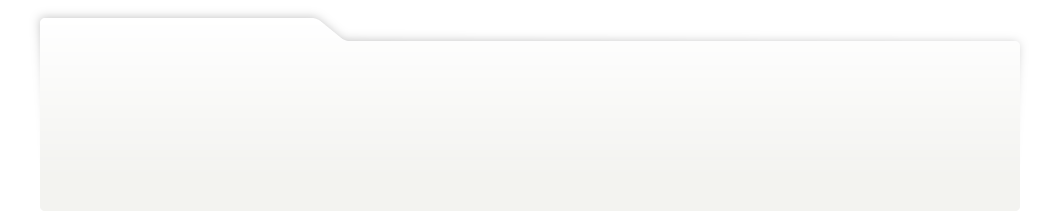
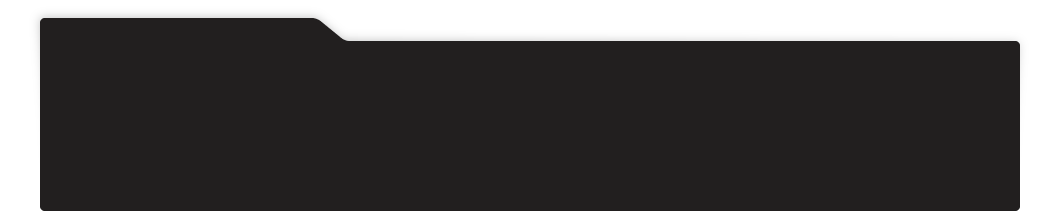
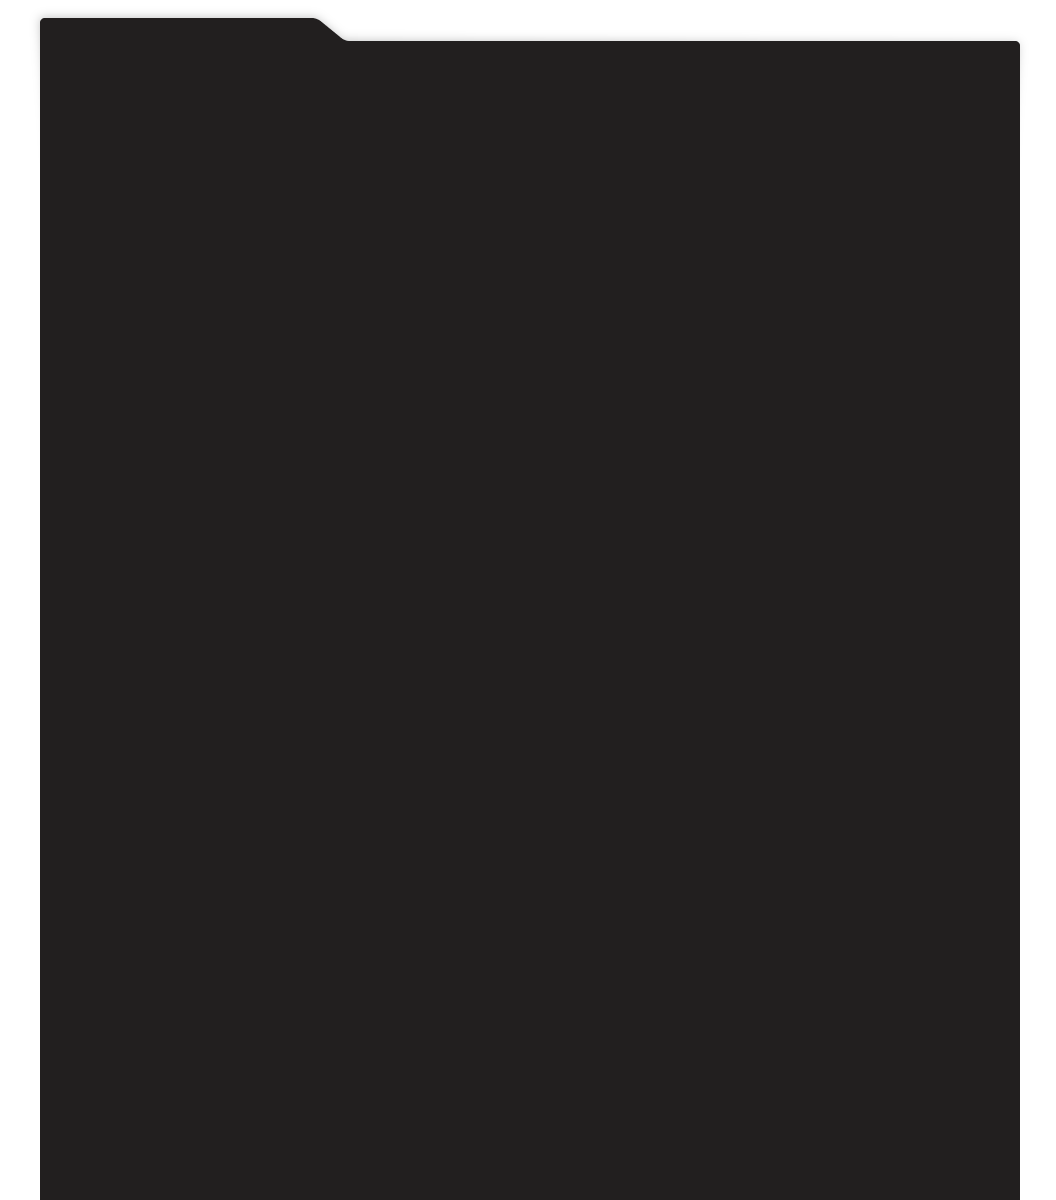
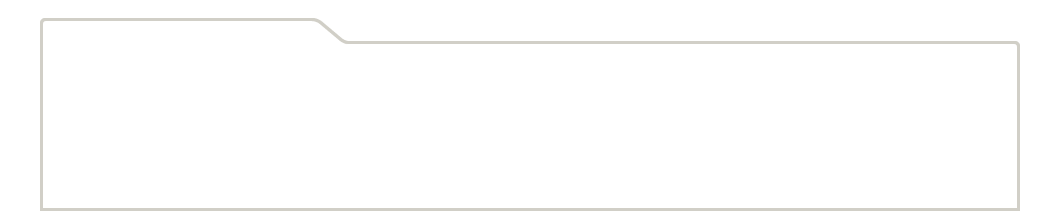
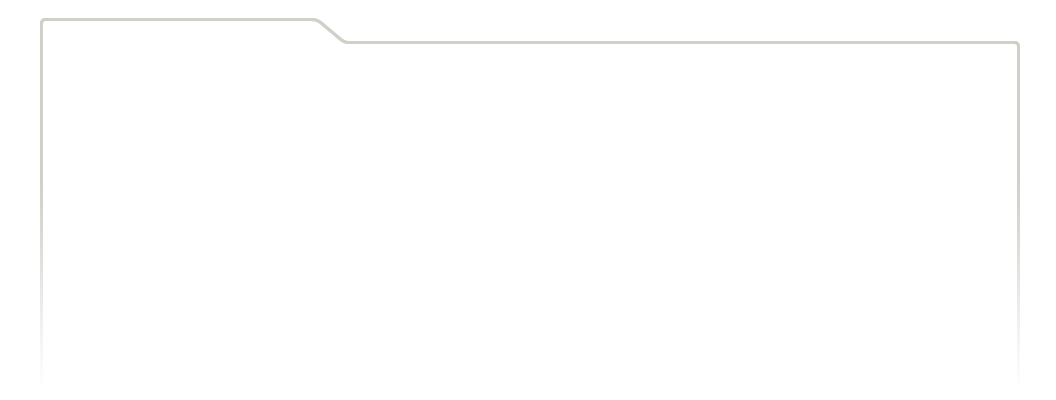
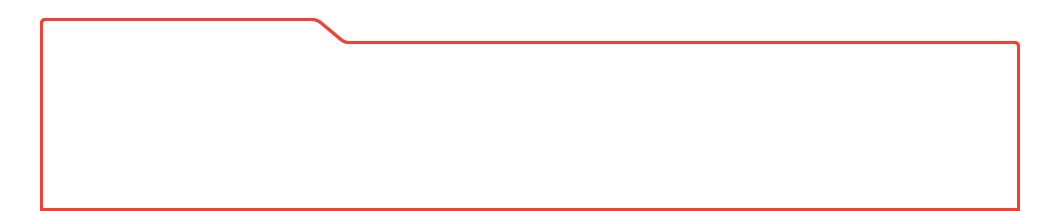
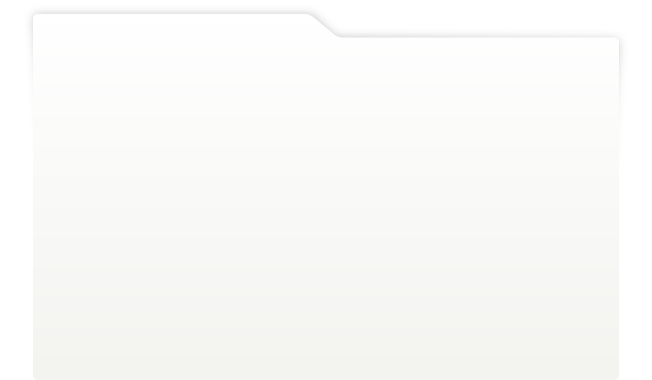
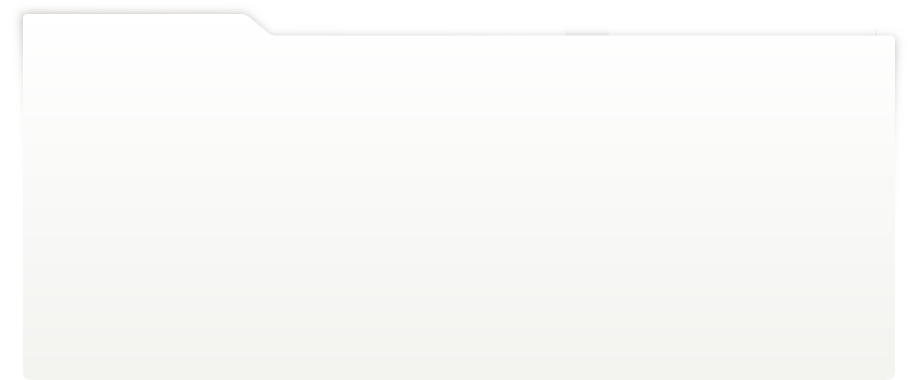
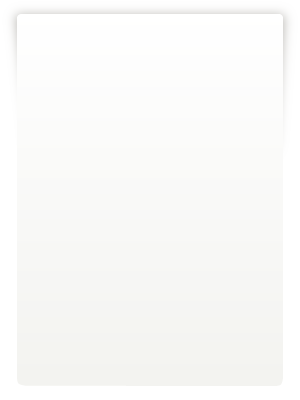
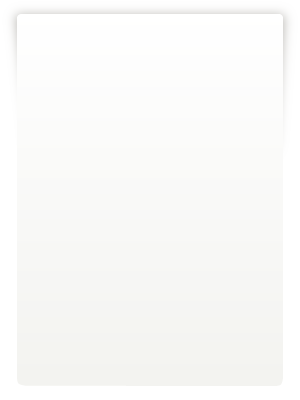
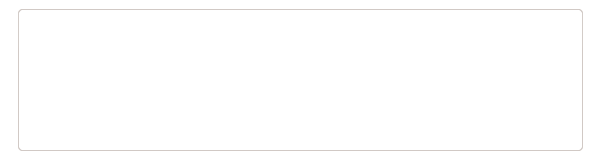
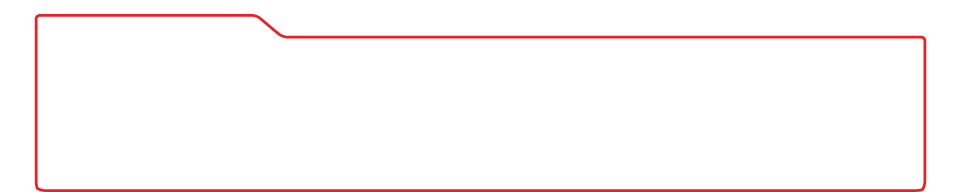
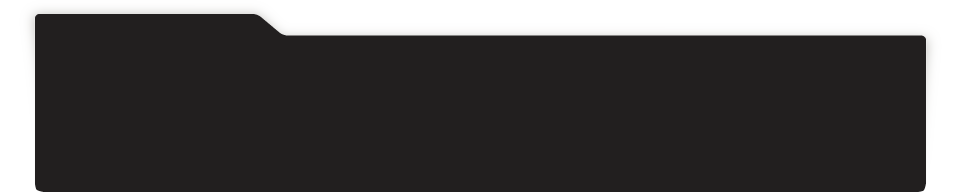
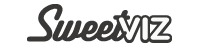
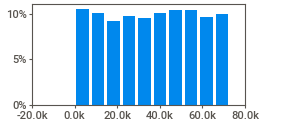
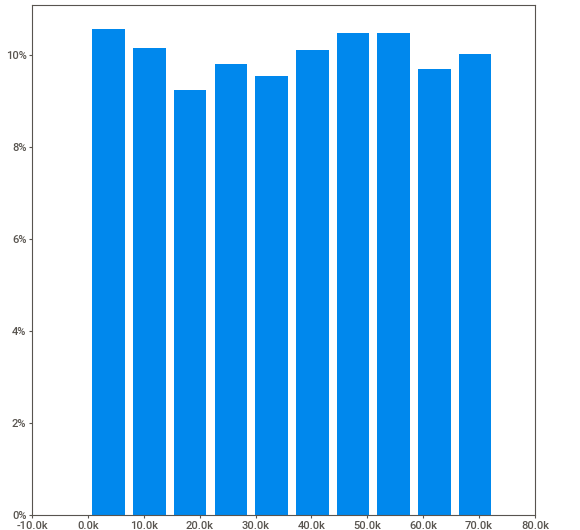
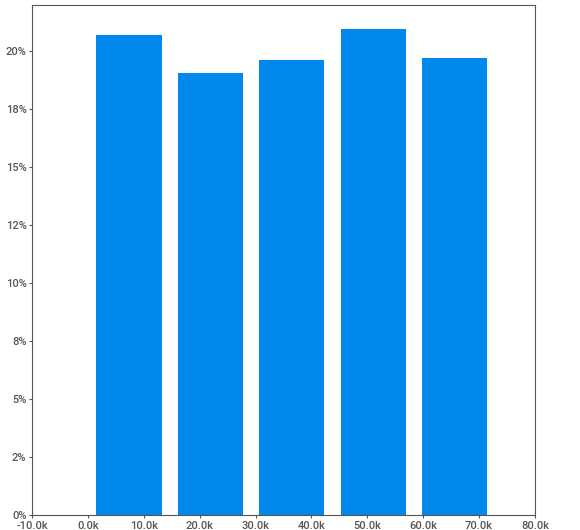
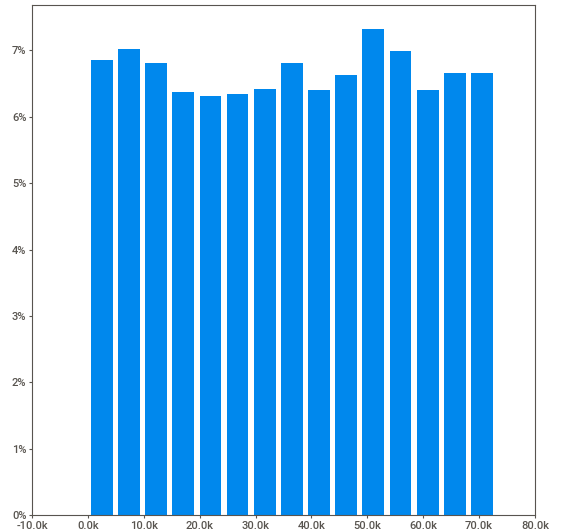
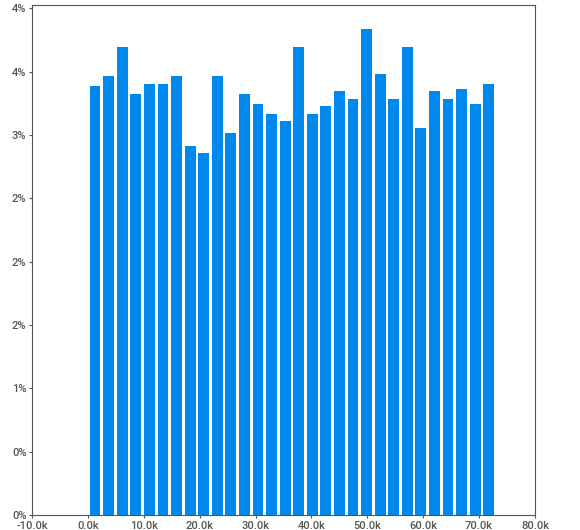
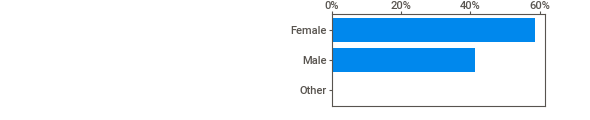
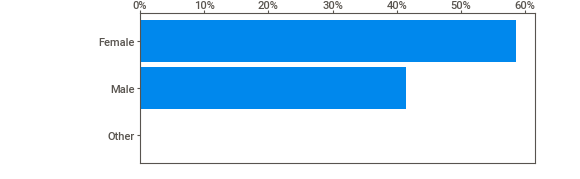
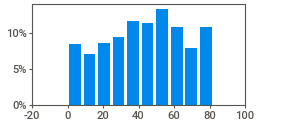
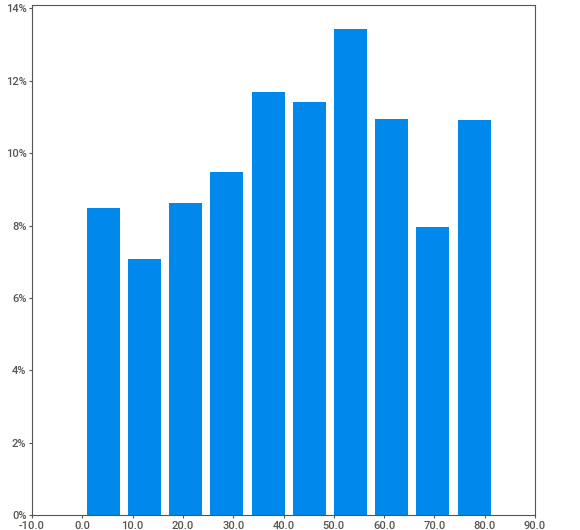
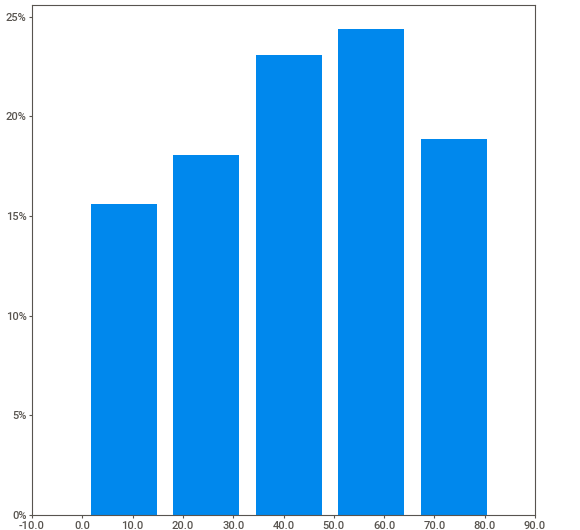
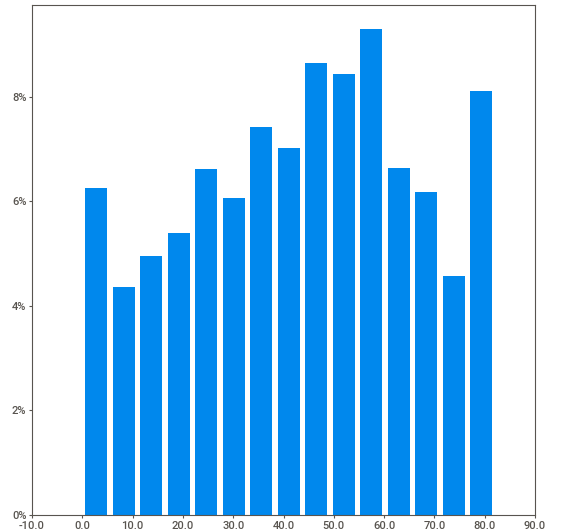
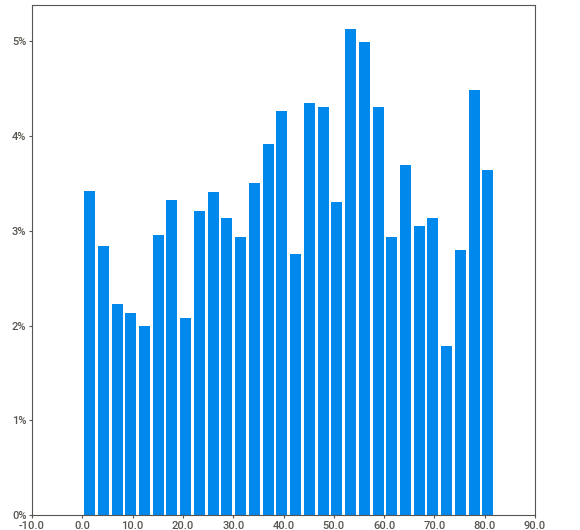
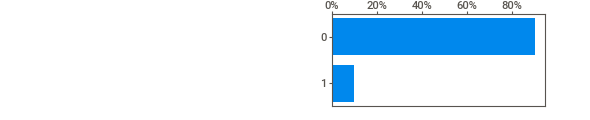
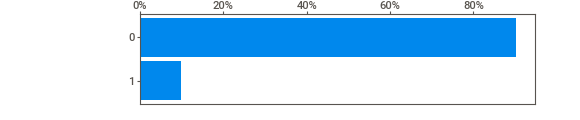
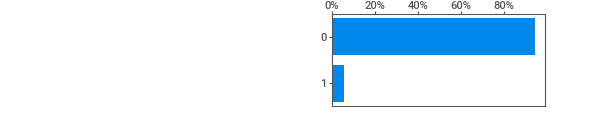
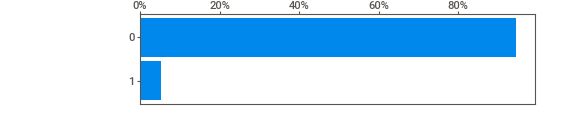
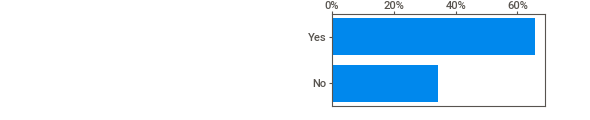
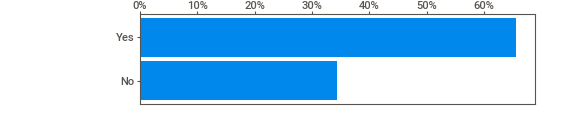
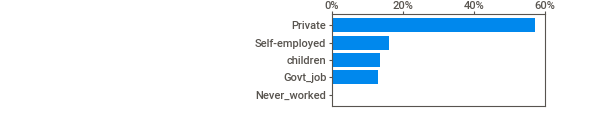
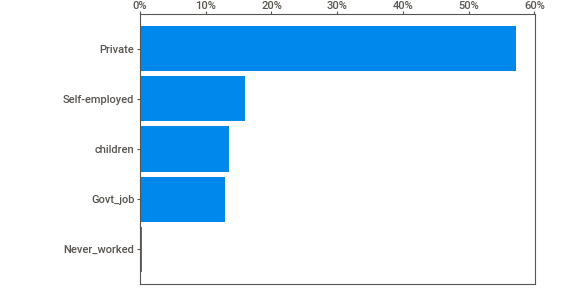
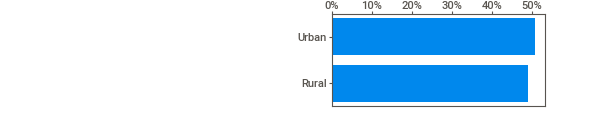
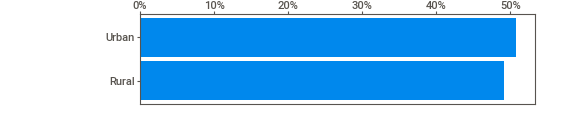
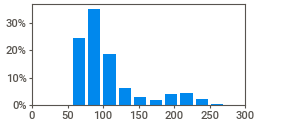
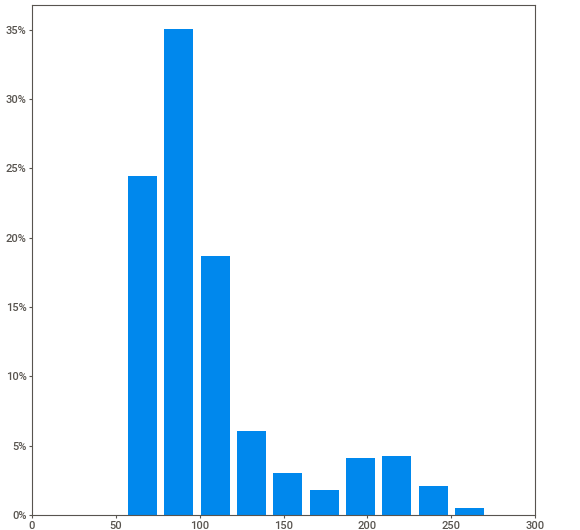
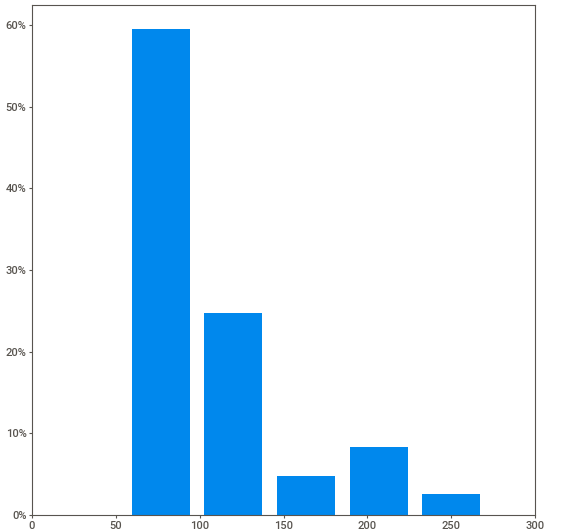
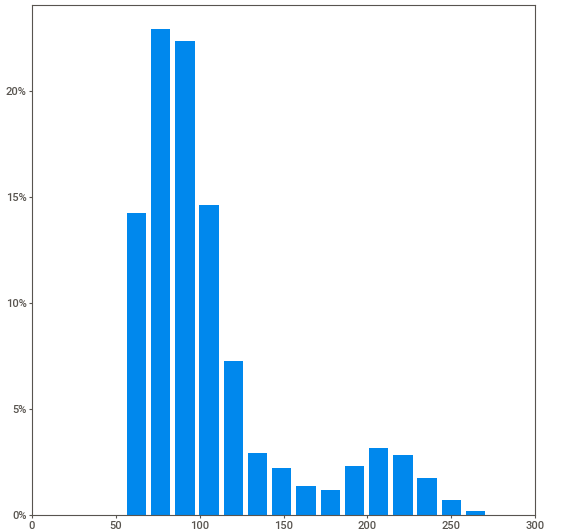
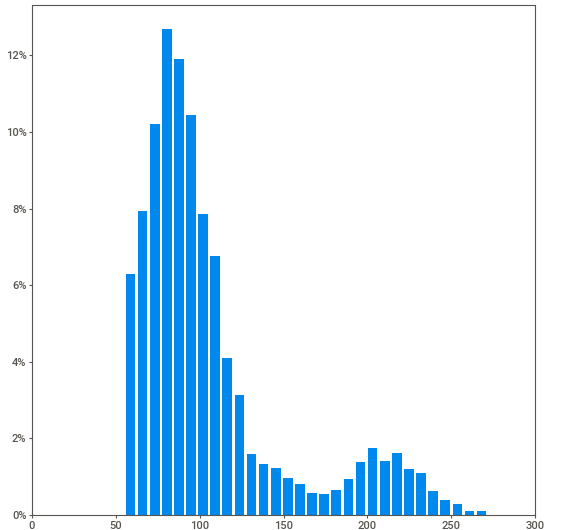
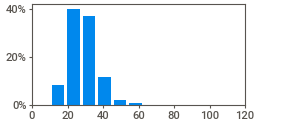
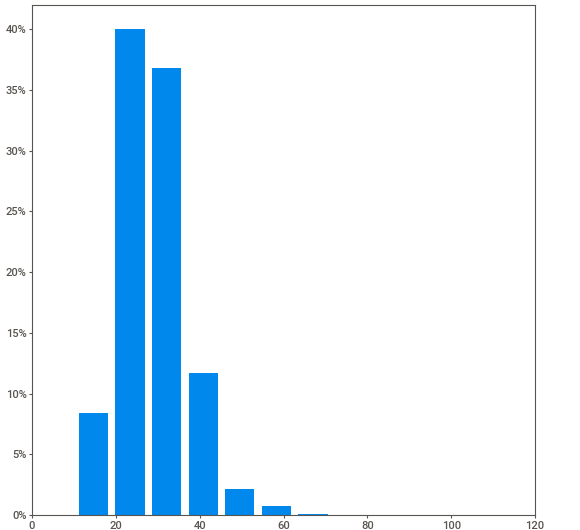
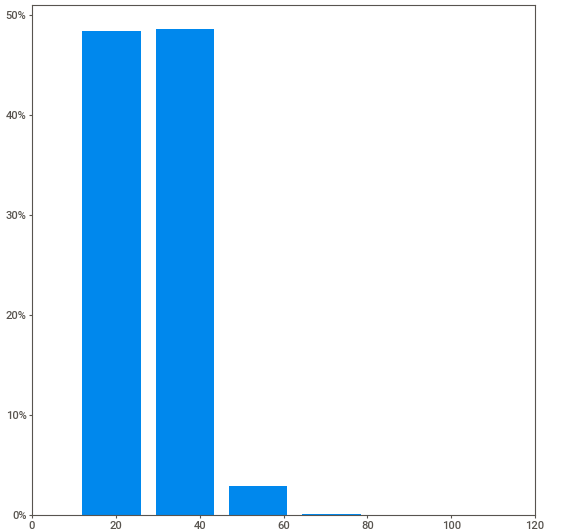
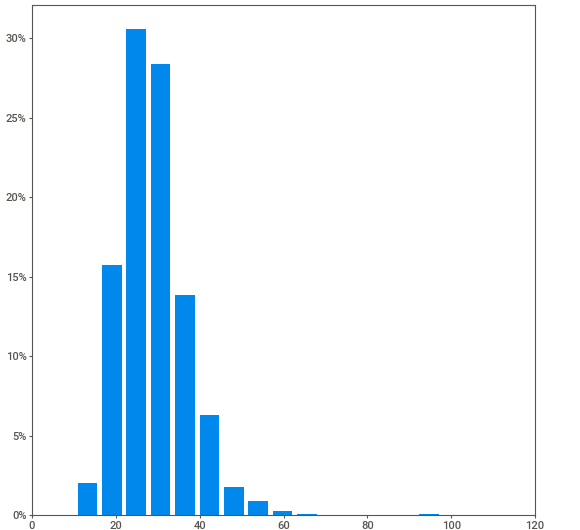
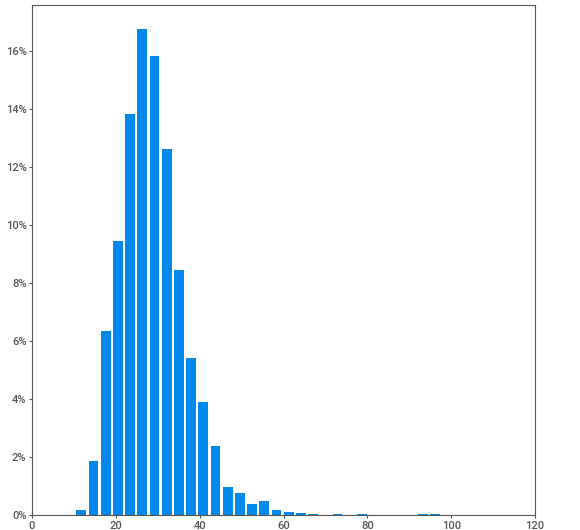
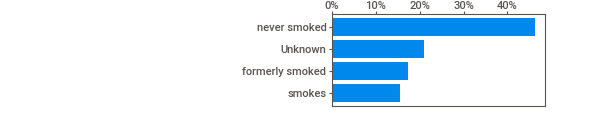
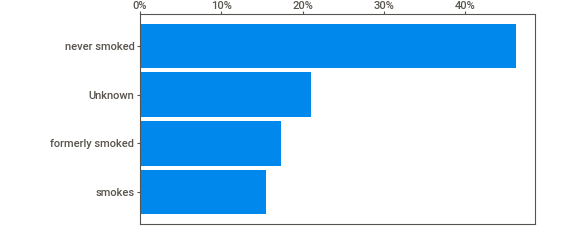
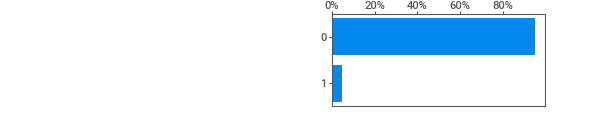
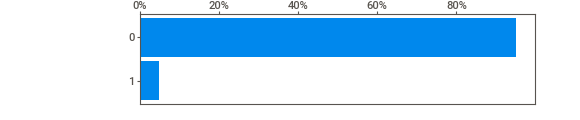
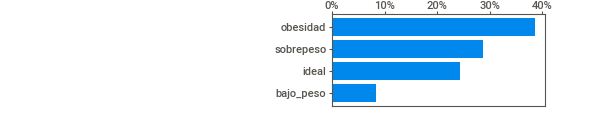
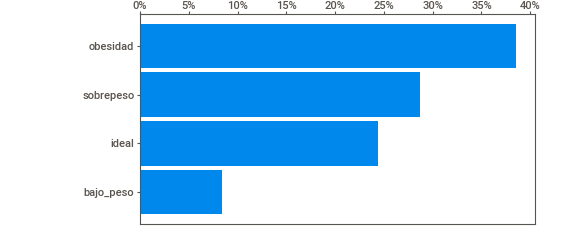
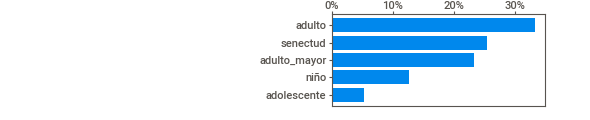
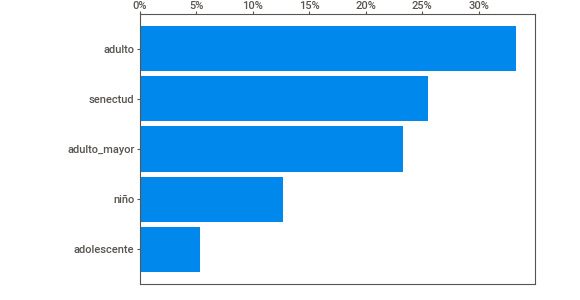
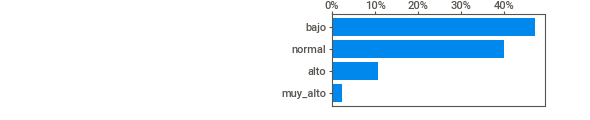
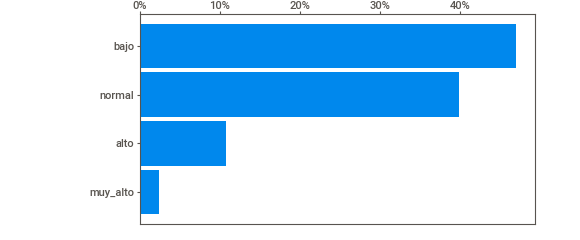
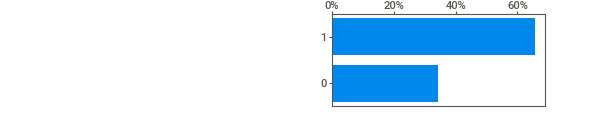
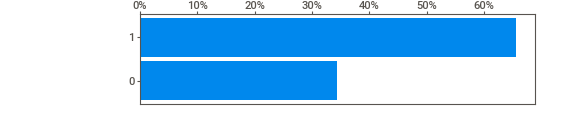
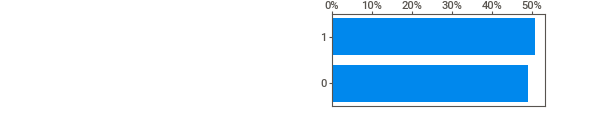
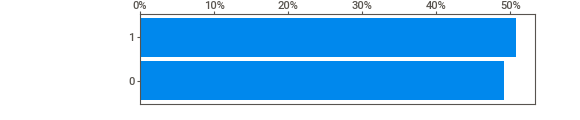
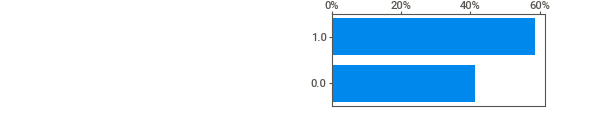
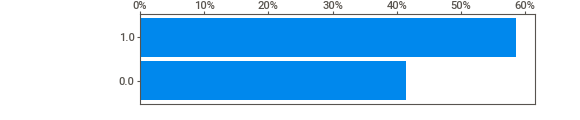
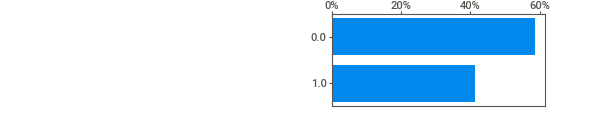
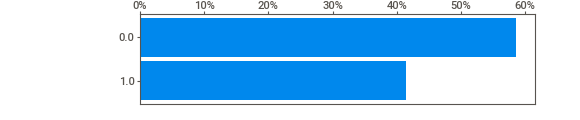
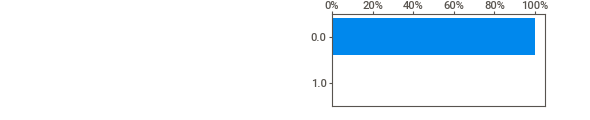
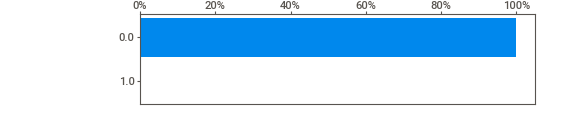
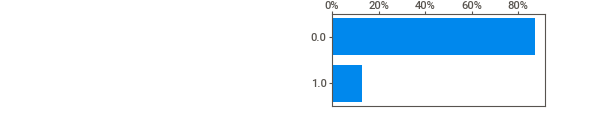
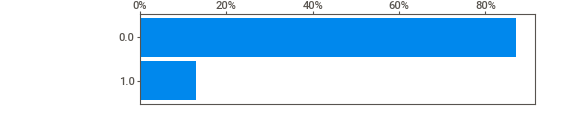
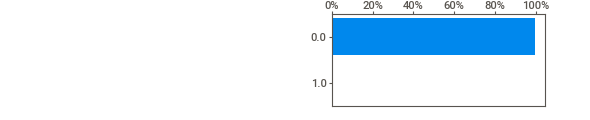
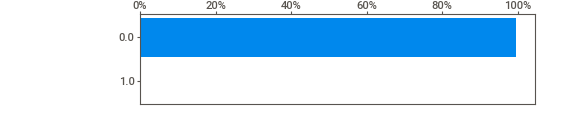
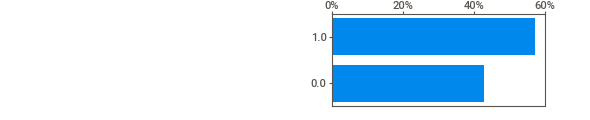
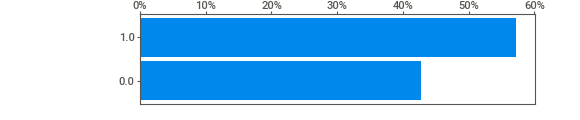
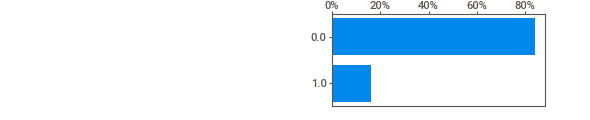
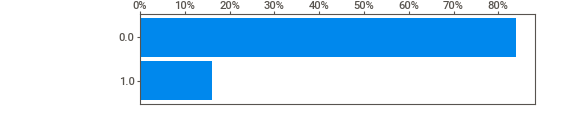
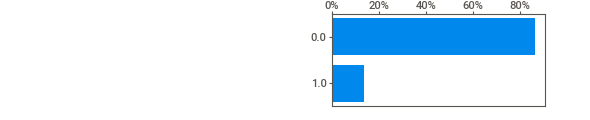
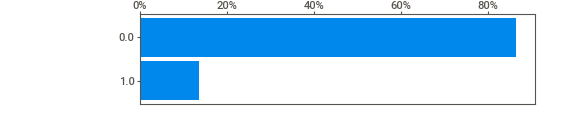
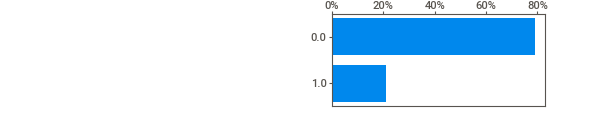
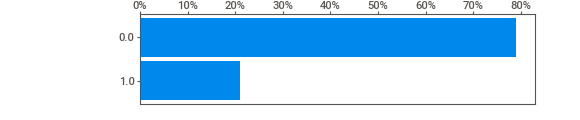
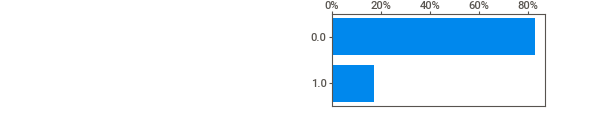
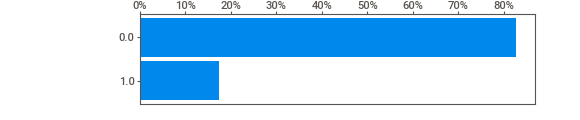
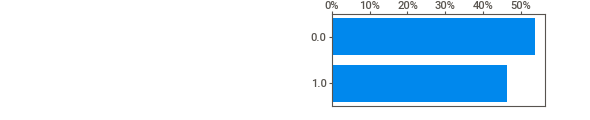
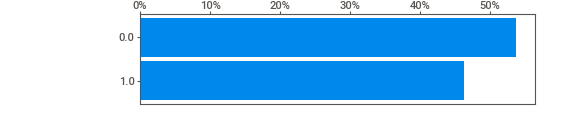
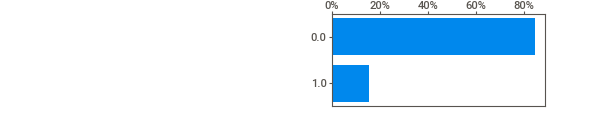
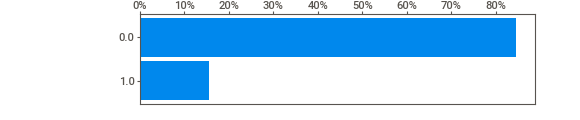
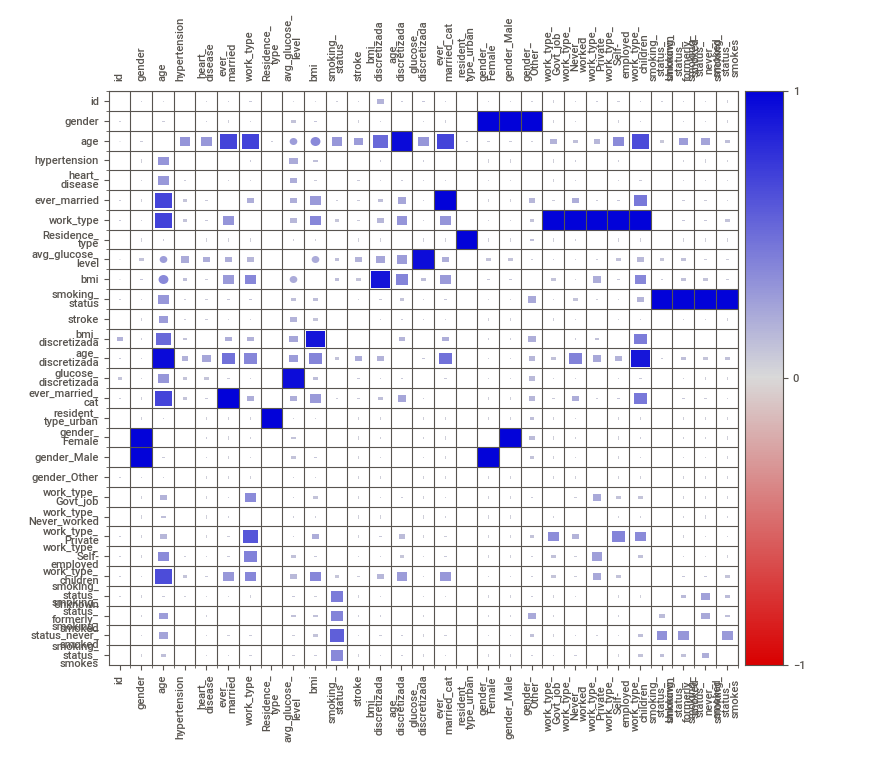
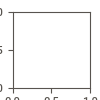

In [38]:
IPython.display.HTML("analize_encoded.html")

In [39]:
# Dataset con encoding
#   * Drop de columnas a las que se hizo el encoding
#      ( Esto es necesario para el correcto trabajo del árbol)
#   * Drop de columnas discretizadas porque no parecen aportar mayor valor
df_encodeado = df_strokes.copy(deep=True)
columns_to_drop = [
    "gender",
    "work_type",
    "Residence_type",
    "ever_married",
    "smoking_status",
    "id",
    "bmi_discretizada",
    "age_discretizada",
    "glucose_discretizada",
]
df_encodeado = df_encodeado.drop(labels=columns_to_drop, axis=1)
df_encodeado.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'ever_married_cat', 'resident_type_urban', 'gender_Female',
       'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly_smoked',
       'smoking_status_never_smoked', 'smoking_status_smokes'],
      dtype='object')

In [40]:
col_encodeadas = [
    "age",
    "hypertension",
    "heart_disease",
    "avg_glucose_level",
    "bmi",
    "ever_married_cat",
    "resident_type_urban",
    "gender_Female",
    "gender_Male",
    "gender_Other",
    "work_type_Govt_job",
    "work_type_Never_worked",
    "work_type_Private",
    "work_type_Self-employed",
    "work_type_children",
    "smoking_status_Never_worked",
    "smoking_status_Unknown",
    "smoking_status_formerly smoked",
    "smoking_status_never smoked",
    "smoking_status_smokes",
]

## Datos faltantes

---
b) Reportar si hay valores faltantes. ¿Cuántos son y en qué atributos se encuentran? En caso de haberlos, ¿es necesario y posible asignarles un valor?  
***


Encontramos datos faltantes en: **bmi**

* Para hombre, la correlacion edad-bmi es de .42 (Para mujeres .28 y en general .3). 
* Podemos estimar o tomar alguna decisión con 'Unknown'.

Hay un segundo caso, el valor _unknown_ en la columna **smoking_status**. Este valor tiene una doble lectura:

* Dato nulo, el desconocido como un valor nulo, la falta de respuesta
* Dato con valor intrínseco, el desconocido es una opción y aporta valor

Después de discusión, iteraciones probando algunas opciones, decidimos corregir valores atípicos (Children, <12 años y con smoking_status 'unknown'). Pero a otros casos si dejarlos por fuera, porque no teniamos evidencia suficiente como para imputar y entender que eso aporte información.


### BMI

In [41]:
df_strokes["bmi_inputation_mean"] = df_strokes["bmi"]
df_strokes["bmi_inputation_knn"] = df_strokes["bmi"]
df_strokes

id  gender   age hypertension heart_disease ever_married  \
0      9046    Male  67.0            0             1          Yes   
1     51676  Female  61.0            0             0          Yes   
2     31112    Male  80.0            0             1          Yes   
3     60182  Female  49.0            0             0          Yes   
4      1665  Female  79.0            1             0          Yes   
...     ...     ...   ...          ...           ...          ...   
5105  18234  Female  80.0            1             0          Yes   
5106  44873  Female  81.0            0             0          Yes   
5107  19723  Female  35.0            0             0          Yes   
5108  37544    Male  51.0            0             0          Yes   
5109  44679  Female  44.0            0             0          Yes   

          work_type Residence_type  avg_glucose_level   bmi  ...  \
0           Private          Urban             228.69  36.6  ...   
1     Self-employed          Rural             202.21   NaN  ...   
2           Private          Rural             105.92  32.5  ...   
3           Private          Urban             171.23  34.4  ...   
4     Self-employed          Rural             174.12  24.0  ...   
...             ...            ...                ...   ...  ...   
5105        Private          Urban              83.75   NaN  ...   
5106  Self-employed          Urban             125.20  40.0  ...   
5107  Self-employed          Rural              82.99  30.6  ...   
5108        Private          Rural             166.29  25.6  ...   
5109       Govt_job          Urban              85.28  26.2  ...   

     work_type_Never_worked work_type_Private work_type_Self-employed  \
0                       0.0               1.0                     0.0   
1                       0.0               0.0                     1.0   
2                       0.0               1.0                     0.0   
3                       0.0               1.0                     0.0   
4                       0.0               0.0                     1.0   
...                     ...               ...                     ...   
5105                    0.0               1.0                     0.0   
5106                    0.0               0.0                     1.0   
5107                    0.0               0.0                     1.0   
5108                    0.0               1.0                     0.0   
5109                    0.0               0.0                     0.0   

     work_type_children smoking_status_Unknown  \
0                   0.0                    0.0   
1                   0.0                    0.0   
2                   0.0                    0.0   
3                   0.0                    0.0   
4                   0.0                    0.0   
...                 ...                    ...   
5105                0.0                    0.0   
5106                0.0                    0.0   
5107                0.0                    0.0   
5108                0.0                    0.0   
5109                0.0                    1.0   

      smoking_status_formerly_smoked  smoking_status_never_smoked  \
0                                1.0                          0.0   
1                                0.0                          1.0   
2                                0.0                          1.0   
3                                0.0                          0.0   
4                                0.0                          1.0   
...                              ...                          ...   
5105                             0.0                          1.0   
5106                             0.0                          1.0   
5107                             0.0                          1.0   
5108                             1.0                          0.0   
5109                             0.0                          0.0   

      smoking_status_smokes  bmi_inputation_mean  bmi_in

Imputación:
- BMI
  - Media general
  - Por la media segmentada
  - KNN
  
- **TBD** H2O no es para imputación sino que es un otro modelo más robusto. ¿Hacer una última corrida y comparar con el mejor árbol? 
  - H2O es un otro algoritmo que hace no se ve complicado con el manejo de variables categóricas y missing values. (ver este tema desde el notebook)


Correlación entre variables numéricas y bmi para elegir cual variable usar para media agrupada por algun criterio

<AxesSubplot:>

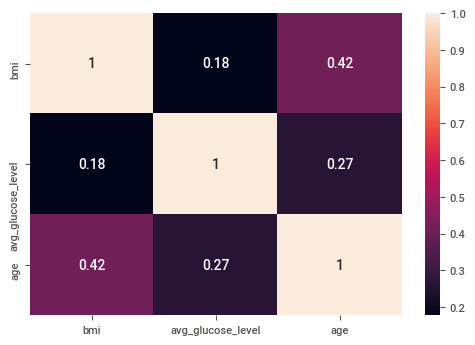

In [42]:
df_hombres = df_strokes[df_strokes.gender == "Male"]
sns.heatmap(data=df_hombres[["bmi", "avg_glucose_level", "age"]].corr(), annot=True)

<AxesSubplot:>

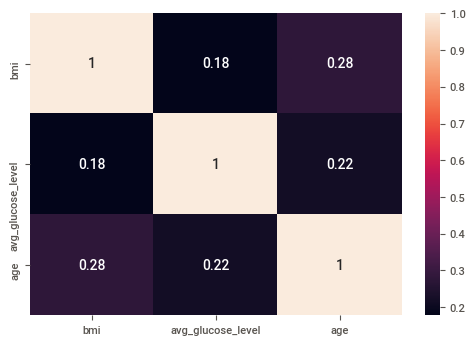

In [43]:
df_hombres = df_strokes[df_strokes.gender == "Female"]
sns.heatmap(data=df_hombres[["bmi", "avg_glucose_level", "age"]].corr(), annot=True)

**TBD**: r y r^2?

/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='bmi', ylabel='work_type'>

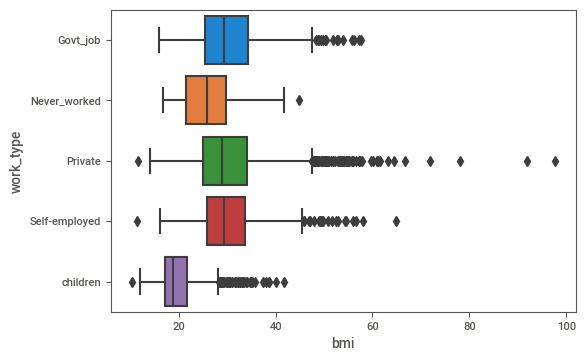

In [44]:
# TBD: Grafica relación en BMI-work_type
# Aporta? O hacer ruido?
# Sumar puntos con color según stroke?
sns.boxplot(df_strokes.bmi, df_strokes.work_type)

**TBD** 
Conclusión de que pensamos, que probamos, y porque nos quedamos con KNN?

### Imputacion BMI


In [45]:
# Media general
df_strokes.bmi.mean()

28.893236911794666

In [46]:
# Imputación por media
df_strokes.bmi_inputation_mean = df_strokes.bmi_inputation_mean.fillna(
    value=df_strokes.bmi.mean()
)
df_strokes[df_strokes.bmi.isna()]

id  gender   age hypertension heart_disease ever_married  \
1     51676  Female  61.0            0             0          Yes   
8     27419  Female  59.0            0             0          Yes   
13     8213    Male  78.0            0             1          Yes   
19    25226    Male  57.0            0             1           No   
27    61843    Male  58.0            0             0          Yes   
...     ...     ...   ...          ...           ...          ...   
5039  42007    Male  41.0            0             0           No   
5048  28788    Male  40.0            0             0          Yes   
5093  32235  Female  45.0            1             0          Yes   
5099   7293    Male  40.0            0             0          Yes   
5105  18234  Female  80.0            1             0          Yes   

          work_type Residence_type  avg_glucose_level  bmi  ...  \
1     Self-employed          Rural             202.21  NaN  ...   
8           Private          Rural              76.15  NaN  ...   
13          Private          Urban             219.84  NaN  ...   
19         Govt_job          Urban             217.08  NaN  ...   
27          Private          Rural             189.84  NaN  ...   
...             ...            ...                ...  ...  ...   
5039        Private          Rural              70.15  NaN  ...   
5048        Private          Urban             191.15  NaN  ...   
5093       Govt_job          Rural              95.02  NaN  ...   
5099        Private          Rural              83.94  NaN  ...   
5105        Private          Urban              83.75  NaN  ...   

     work_type_Never_worked work_type_Private work_type_Self-employed  \
1                       0.0               0.0                     1.0   
8                       0.0               1.0                     0.0   
13                      0.0               1.0                     0.0   
19                      0.0               0.0                     0.0   
27                      0.0               1.0                     0.0   
...                     ...               ...                     ...   
5039                    0.0               1.0                     0.0   
5048                    0.0               1.0                     0.0   
5093                    0.0               0.0                     0.0   
5099                    0.0               1.0                     0.0   
5105                    0.0               1.0                     0.0   

     work_type_children smoking_status_Unknown  \
1                   0.0                    0.0   
8                   0.0                    1.0   
13                  0.0                    1.0   
19                  0.0                    1.0   
27                  0.0                    1.0   
...                 ...                    ...   
5039                0.0                    0.0   
5048                0.0                    0.0   
5093                0.0                    0.0   
5099                0.0                    0.0   
5105                0.0                    0.0   

      smoking_status_formerly_smoked  smoking_status_never_smoked  \
1                                0.0                          1.0   
8                                0.0                          0.0   
13                               0.0                          0.0   
19                               0.0                          0.0   
27                               0.0                          0.0   
...                              ...                          ...   
5039                             1.0                          0.0   
5048                             0.0                          0.0   
5093                             0.0                          0.0   
5099                             0.0                          0.0   
5105                             0.0                          1.0   

      smoking_status_smokes  bmi_inputation_mean  bmi_inputation_knn

In [47]:
# Imputación por media de cada tipo de work_type
df_strokes["bmi_inputation_work_type"] = df_strokes.bmi
for tipo in df_strokes.work_type.unique().to_list():
    df_strokes.loc[
        (df_strokes.work_type == tipo), "bmi_inputation_work_type"
    ] = df_strokes[df_strokes["work_type"] == tipo].bmi_inputation_work_type.fillna(
        value=df_strokes[df_strokes["work_type"] == tipo].bmi.mean()
    )

In [48]:
df_strokes[
    [
        "age",
        "hypertension",
        "heart_disease",
        "avg_glucose_level",
        "bmi",
        "ever_married_cat",
        "resident_type_urban",
        "gender_Female",
        "gender_Male",
        "gender_Other",
        "work_type_Govt_job",
        "work_type_Never_worked",
        "work_type_Private",
        "work_type_Self-employed",
        "work_type_children",
        "smoking_status_Unknown",
        "smoking_status_formerly_smoked",
        "smoking_status_never_smoked",
        "smoking_status_smokes",
        "stroke",
    ]
]

age hypertension heart_disease  avg_glucose_level   bmi  \
0     67.0            0             1             228.69  36.6   
1     61.0            0             0             202.21   NaN   
2     80.0            0             1             105.92  32.5   
3     49.0            0             0             171.23  34.4   
4     79.0            1             0             174.12  24.0   
...    ...          ...           ...                ...   ...   
5105  80.0            1             0              83.75   NaN   
5106  81.0            0             0             125.20  40.0   
5107  35.0            0             0              82.99  30.6   
5108  51.0            0             0             166.29  25.6   
5109  44.0            0             0              85.28  26.2   

      ever_married_cat  resident_type_urban  gender_Female  gender_Male  \
0                    1                    1            0.0          1.0   
1                    1                    0            1.0          0.0   
2                    1                    0            0.0          1.0   
3                    1                    1            1.0          0.0   
4                    1                    0            1.0          0.0   
...                ...                  ...            ...          ...   
5105                 1                    1            1.0          0.0   
5106                 1                    1            1.0          0.0   
5107                 1                    0            1.0          0.0   
5108                 1                    0            0.0          1.0   
5109                 1                    1            1.0          0.0   

      gender_Other  work_type_Govt_job  work_type_Never_worked  \
0              0.0                 0.0                     0.0   
1              0.0                 0.0                     0.0   
2              0.0                 0.0                     0.0   
3              0.0                 0.0                     0.0   
4              0.0                 0.0                     0.0   
...            ...                 ...                     ...   
5105           0.0                 0.0                     0.0   
5106           0.0                 0.0                     0.0   
5107           0.0                 0.0                     0.0   
5108           0.0                 0.0                     0.0   
5109           0.0                 1.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
0                   1.0                      0.0                 0.0   
1                   0.0                      1.0                 0.0   
2                   1.0                      0.0                 0.0   
3                   1.0                      0.0                 0.0   
4                   0.0                      1.0                 0.0   
...                 ...                      ...                 ...   
5105                1.0                      0.0                 0.0   
5106                0.0                      1.0                 0.0   
5107                0.0                      1.0                 0.0   
5108                1.0                      0.0                 0.0   
5109                0.0                      0.0                 0.0   

      smoking_status_Unknown  smoking_status_formerly_smoked  \
0                        0.0                             1.0   
1                        0.0                             0.0   
2                        0.0                             0.0   
3                        0.0                             0.0   
4                        0.0                             0.0   
...                      ...                             ...   
5105                     0.0                             0.0   
5106                     0.0                             0.0   
5107                     0.0                             0.0   
5108           

>1 0.215 (0.023)
>3 0.214 (0.019)
>5 0.214 (0.018)
>7 0.211 (0.020)
>9 0.210 (0.020)
>15 0.212 (0.021)
>18 0.210 (0.023)
>21 0.215 (0.027)


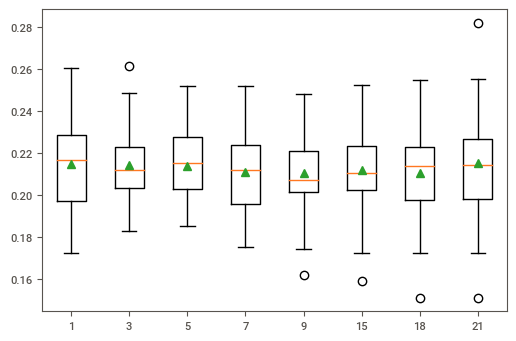

In [49]:
# ref: https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/
X = df_strokes[
    [
        "age",
        "hypertension",
        "heart_disease",
        "avg_glucose_level",
        "bmi",
        "ever_married_cat",
        "resident_type_urban",
        "gender_Female",
        "gender_Male",
        "gender_Other",
        "work_type_Govt_job",
        "work_type_Never_worked",
        "work_type_Private",
        "work_type_Self-employed",
        "work_type_children",
        "smoking_status_Unknown",
        "smoking_status_formerly_smoked",
        "smoking_status_never_smoked",
        "smoking_status_smokes",
    ]
].copy(deep=True)
y = df_strokes["stroke"]

# Iterar por el hiperparámetro
results = list()
strategies = [str(i) for i in [1, 3, 5, 7, 9, 15, 18, 21]] 
for s in strategies:
    
    # Sklearn pipeline, inputador y modelo para testear la métrica
    # Forma muy sencilla de iterar rápido
    pipeline = Pipeline(
        steps=[
            ("i", KNNImputer(n_neighbors=int(s))),
            (
                "m",
                tree.DecisionTreeClassifier(
                    criterion="gini",
                    max_depth=7,
                    min_samples_leaf=5,
                    ccp_alpha=0.002512562814070352,
                    random_state=42,
                    class_weight="balanced",
                ),
            ),
        ]
    )
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    # F1 para tener un parámetro estándar que equilibra precision y recall
#     scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    scores = cross_val_score(pipeline, X, y, scoring="f1", cv=cv, n_jobs=-1)

    results.append(scores)
    # 5 parece se interesante, tiene un score alto, con una dimensionalidad 'baja' y una dispersión 'pequeña'
    print(">%s %.3f (%.3f)" % (s, mean(scores), std(scores)))
    
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

In [50]:
# Imputación por KNN
knn_imputer = KNNImputer(n_neighbors=5)

df_strokes_knn = df_strokes[
    [
        "age",
        "hypertension",
        "heart_disease",
        "avg_glucose_level",
        "bmi",
        "ever_married_cat",
        "resident_type_urban",
        "gender_Female",
        "gender_Male",
        "gender_Other",
        "work_type_Govt_job",
        "work_type_Never_worked",
        "work_type_Private",
        "work_type_Self-employed",
        "work_type_children",
        "smoking_status_Unknown",
        "smoking_status_formerly_smoked",
        "smoking_status_never_smoked",
        "smoking_status_smokes",
        "stroke",
    ]
].copy(deep=True)
df_strokes_knn.iloc[:, :] = knn_imputer.fit_transform(df_strokes_knn)

In [51]:
# Check de imputación KNN
df_strokes_knn[df_strokes.bmi.isna()]

age  hypertension  heart_disease  avg_glucose_level    bmi  \
1     61.0           0.0            0.0             202.21  32.56   
8     59.0           0.0            0.0              76.15  24.64   
13    78.0           0.0            1.0             219.84  29.90   
19    57.0           0.0            1.0             217.08  33.10   
27    58.0           0.0            0.0             189.84  33.00   
...    ...           ...            ...                ...    ...   
5039  41.0           0.0            0.0              70.15  35.70   
5048  40.0           0.0            0.0             191.15  33.56   
5093  45.0           1.0            0.0              95.02  31.10   
5099  40.0           0.0            0.0              83.94  29.66   
5105  80.0           1.0            0.0              83.75  27.84   

      ever_married_cat  resident_type_urban  gender_Female  gender_Male  \
1                  1.0                  0.0            1.0          0.0   
8                  1.0                  0.0            1.0          0.0   
13                 1.0                  1.0            0.0          1.0   
19                 0.0                  1.0            0.0          1.0   
27                 1.0                  0.0            0.0          1.0   
...                ...                  ...            ...          ...   
5039               0.0                  0.0            0.0          1.0   
5048               1.0                  1.0            0.0          1.0   
5093               1.0                  0.0            1.0          0.0   
5099               1.0                  0.0            0.0          1.0   
5105               1.0                  1.0            1.0          0.0   

      gender_Other  work_type_Govt_job  work_type_Never_worked  \
1              0.0                 0.0                     0.0   
8              0.0                 0.0                     0.0   
13             0.0                 0.0                     0.0   
19             0.0                 1.0                     0.0   
27             0.0                 0.0                     0.0   
...            ...                 ...                     ...   
5039           0.0                 0.0                     0.0   
5048           0.0                 0.0                     0.0   
5093           0.0                 1.0                     0.0   
5099           0.0                 0.0                     0.0   
5105           0.0                 0.0                     0.0   

      work_type_Private  work_type_Self-employed  work_type_children  \
1                   0.0                      1.0                 0.0   
8                   1.0                      0.0                 0.0   
13                  1.0                      0.0                 0.0   
19                  0.0                      0.0                 0.0   
27                  1.0                      0.0                 0.0   
...                 ...                      ...                 ...   
5039                1.0                      0.0                 0.0   
5048                1.0                      0.0                 0.0   
5093                0.0                      0.0                 0.0   
5099                1.0                      0.0                 0.0   
5105                1.0                      0.0                 0.0   

      smoking_status_Unknown  smoking_status_formerly_smoked  \
1                        0.0                             0.0   
8                        1.0                             0.0   
13                       1.0                             0.0   
19                       1.0                             0.0   
27                       1.0                             0.0   
...                      ...                             ...   
5039                     0.0                             1.0   
5048                     0.0                             0.0   
5093                     0.0               

In [52]:
df_strokes["bmi_inputation_knn"] = df_strokes_knn.bmi

In [53]:
# Check de todas las imputaciones
df_strokes[df_strokes.bmi.isna()]

id  gender   age hypertension heart_disease ever_married  \
1     51676  Female  61.0            0             0          Yes   
8     27419  Female  59.0            0             0          Yes   
13     8213    Male  78.0            0             1          Yes   
19    25226    Male  57.0            0             1           No   
27    61843    Male  58.0            0             0          Yes   
...     ...     ...   ...          ...           ...          ...   
5039  42007    Male  41.0            0             0           No   
5048  28788    Male  40.0            0             0          Yes   
5093  32235  Female  45.0            1             0          Yes   
5099   7293    Male  40.0            0             0          Yes   
5105  18234  Female  80.0            1             0          Yes   

          work_type Residence_type  avg_glucose_level  bmi  ...  \
1     Self-employed          Rural             202.21  NaN  ...   
8           Private          Rural              76.15  NaN  ...   
13          Private          Urban             219.84  NaN  ...   
19         Govt_job          Urban             217.08  NaN  ...   
27          Private          Rural             189.84  NaN  ...   
...             ...            ...                ...  ...  ...   
5039        Private          Rural              70.15  NaN  ...   
5048        Private          Urban             191.15  NaN  ...   
5093       Govt_job          Rural              95.02  NaN  ...   
5099        Private          Rural              83.94  NaN  ...   
5105        Private          Urban              83.75  NaN  ...   

     work_type_Private work_type_Self-employed work_type_children  \
1                  0.0                     1.0                0.0   
8                  1.0                     0.0                0.0   
13                 1.0                     0.0                0.0   
19                 0.0                     0.0                0.0   
27                 1.0                     0.0                0.0   
...                ...                     ...                ...   
5039               1.0                     0.0                0.0   
5048               1.0                     0.0                0.0   
5093               0.0                     0.0                0.0   
5099               1.0                     0.0                0.0   
5105               1.0                     0.0                0.0   

     smoking_status_Unknown smoking_status_formerly_smoked  \
1                       0.0                            0.0   
8                       1.0                            0.0   
13                      1.0                            0.0   
19                      1.0                            0.0   
27                      1.0                            0.0   
...                     ...                            ...   
5039                    0.0                            1.0   
5048                    0.0                            0.0   
5093                    0.0                            0.0   
5099                    0.0                            0.0   
5105                    0.0                            0.0   

      smoking_status_never_smoked  smoking_status_smokes  bmi_inputation_mean  \
1                             1.0                    0.0            28.893237   
8                             0.0                    0.0            28.893237   
13                            0.0                    0.0            28.893237   
19                            0.0                    0.0            28.893237   
27                            0.0                    0.0            28.893237   
...                           ...                    ...                  ...   
5039                          0.0                    0.0            28.893237   
5048                          0.0                    1.0            28.893237   
5093                          0.0                    1.0            28.8

In [54]:
df_strokes.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'bmi_discretizada', 'age_discretizada',
       'glucose_discretizada', 'ever_married_cat', 'resident_type_urban',
       'gender_Female', 'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly_smoked',
       'smoking_status_never_smoked', 'smoking_status_smokes',
       'bmi_inputation_mean', 'bmi_inputation_knn',
       'bmi_inputation_work_type'],
      dtype='object')

<AxesSubplot:>

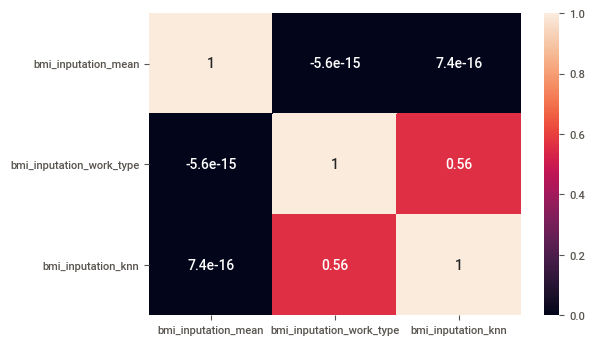

In [55]:
# Correlación entre inputs
df_corr = df_strokes[
    df_strokes.bmi.isna()
]  # [['bmi', 'bmi_inputation_mean', 'bmi_inputation_work_type', 'bmi_inputation_knn']]
sns.heatmap(
    data=df_corr[
        ["bmi_inputation_mean", "bmi_inputation_work_type", "bmi_inputation_knn"]
    ].corr(),
    annot=True,
)

## Correlación


c) ¿Qué variables se correlacionan más con el evento de lesión (Stroke)? Para las cuatro más correlacionadas, realizar un gráfico en el que se pueda observar la correlación entre la variable y el stroke.   
***

Heart_disease, work_type, hypertension, 

In [56]:
# Para caso stroke positivo
#   Hay una gran variación en el caso de heart_disease (0,04 -> 0,17)
ct = pd.crosstab(
    index=df_strokes["heart_disease"],
    columns=df_strokes["stroke"],
    margins=True,
    normalize="index",
)
ct

stroke                0         1
heart_disease                    
0              0.958213  0.041787
1              0.829710  0.170290
All            0.951272  0.048728

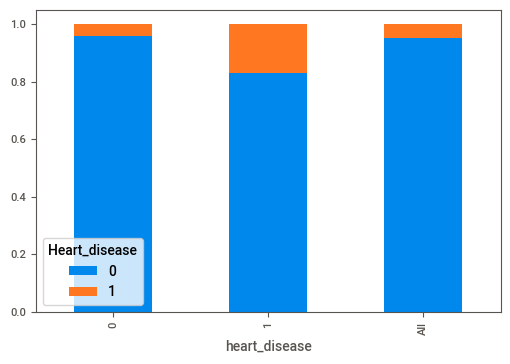

In [57]:
# En la condición heart_disease = 1, la probabilidad de stroke cuatriplica.
ct.plot.bar(stacked=True)
plt.legend(title='Heart_disease')
plt.show()

In [58]:
# Para caso stroke positivo
#   Hay algunos valores interesantes:
#   * 0 en never_worked
#   * 0,002 en children
ct = pd.crosstab(
    index=df_strokes["work_type"],
    columns=df_strokes["stroke"],
    margins=True,
    normalize="index",
)
ct 

stroke                0         1
work_type                        
Govt_job       0.949772  0.050228
Never_worked   1.000000  0.000000
Private        0.949042  0.050958
Self-employed  0.920538  0.079462
children       0.997110  0.002890
All            0.951272  0.048728

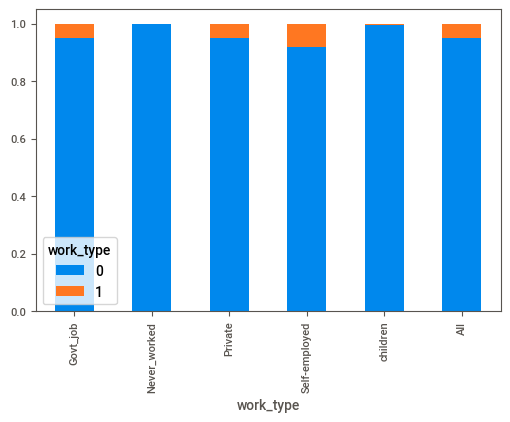

In [59]:
# En los work_type children y never_worked la probabilidad de stroke es 0, o tiende a 0. 
# En self_employed es mayor que las otras incluso csai un 60% más que en govt_job
ct.plot.bar(stacked=True)
plt.legend(title='work_type')
plt.show()

In [60]:
# Para caso stroke positivo
#   Hay una gran variación en el caso de hypertension (0,03 -> 0,13)
ct = pd.crosstab(
    index=df_strokes["hypertension"],
    columns=df_strokes["stroke"],
    margins=True,
    normalize="index",
)
ct

stroke               0         1
hypertension                    
0             0.960321  0.039679
1             0.867470  0.132530
All           0.951272  0.048728

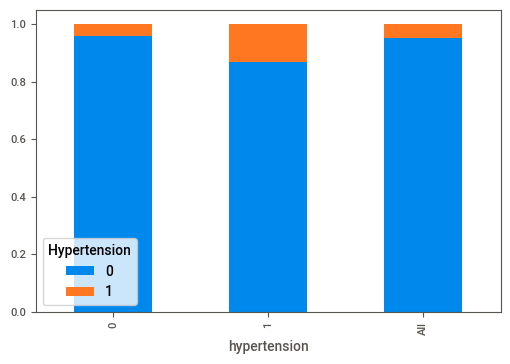

In [61]:
# En la condición hypertension = 1, la probabilidad de stroke casi cuatriplica.
ct.plot.bar(stacked=True)
plt.legend(title='Hypertension')
plt.show()

Lo curioso para hypertension y heart_disease es que luego no fueron relevantes para la toma de decisiones del árbol. 

**TBD** no aporta información nueva porque está implicita en edad?
Grafico comparando edad-hypertension-heart_disease y stroke.

* Gender, residence_type, smoking_status -> no parecen aportar tanta información 

Numericas

<AxesSubplot:xlabel='stroke', ylabel='age'>

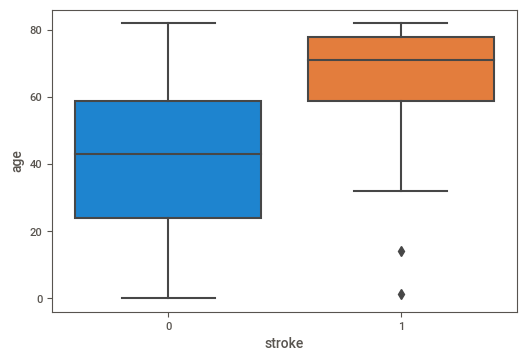

In [62]:
# Este gráfico esta más abajo
sns.boxplot(x="stroke", y="age", data=df_strokes)

<AxesSubplot:xlabel='stroke', ylabel='age'>

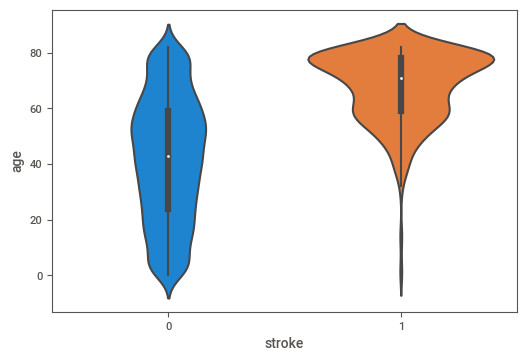

In [63]:
# El gráfico de violín para stroke, negativo y positivo,
#    son muy diferentes. Hay un componente fuerte de la 
#    edad que explica el stroke (ACV?)
sns.violinplot(x="stroke", y="age", data=df_original)

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

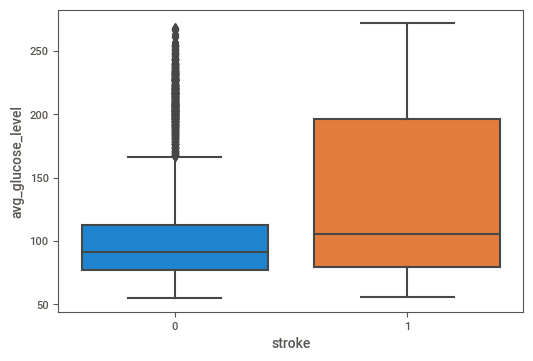

In [64]:
# Este gráfico esta más abajo
sns.boxplot(x="stroke", y="avg_glucose_level", data=df_strokes)

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

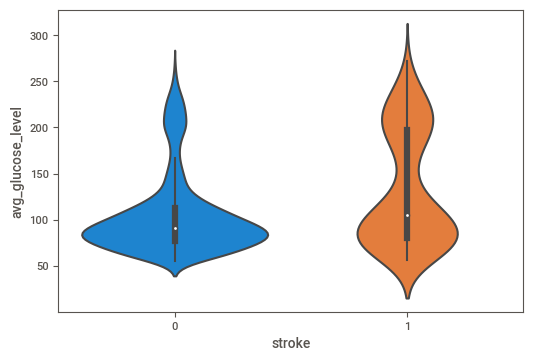

In [65]:
sns.violinplot(x="stroke", y="avg_glucose_level", data=df_original)

# avg_glucose_level -> Parece ser bimodal y en caso de glucosa alta para stroke, hay información relevante

En la relacion bmi-stroke no vemos tanto aporte de información. Las curvas se superponen.


<AxesSubplot:xlabel='stroke', ylabel='bmi'>

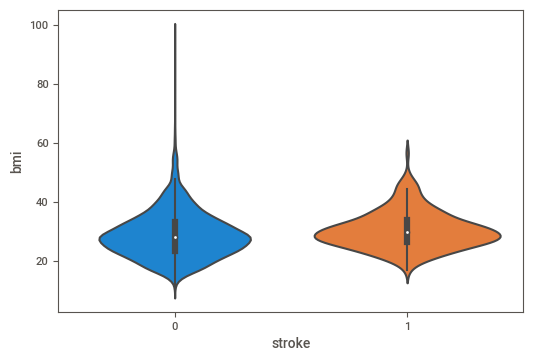

In [66]:
sns.violinplot(x="stroke", y="bmi", data=df_original)

**tbd** 
* ver como puedo hacer que priorizar variables
* multivariado hyptertension-edad -> stroke?
* multivariado heart_disease-edad -> stroke?


In [67]:

ct = pd.crosstab([df_strokes.age_discretizada], df_strokes.stroke,
    margins=True,
#     normalize="index",
)
ct

stroke               0    1   All
age_discretizada                 
niño               644    1   645
adolescente        270    1   271
adulto            1691   11  1702
adulto_mayor      1129   59  1188
senectud          1127  177  1304
All               4861  249  5110

In [68]:
ct = pd.crosstab([df_strokes.heart_disease, df_strokes.age_discretizada], df_strokes.stroke,
    margins=True,
#     normalize="index",
)
ct

stroke                             0    1   All
heart_disease age_discretizada                 
0             niño               643    1   644
              adolescente        270    1   271
              adulto            1684   11  1695
              adulto_mayor      1076   54  1130
              senectud           959  135  1094
1             niño                 1    0     1
              adulto               7    0     7
              adulto_mayor        53    5    58
              senectud           168   42   210
All                             4861  249  5110

In [69]:
# Recordatorio de los bins de edad:
#  * Niño => 0-13
#  * Adolescente => 13-18
#  * Adulto => 18-45
#  * Adulto_mayor => 45-60
#  * Senectud => > 60
# En la tabla se ve que heart_de


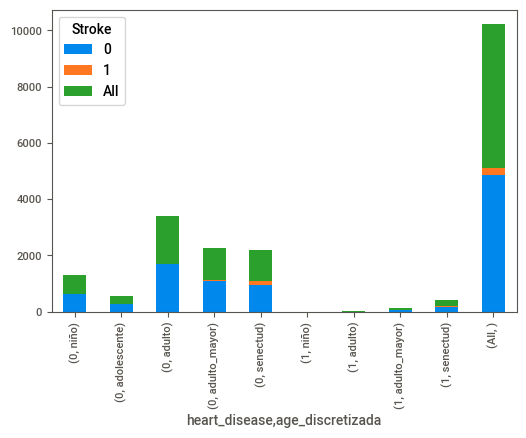

In [70]:
ct.plot.bar(stacked=True)
plt.legend(title='Stroke')
plt.show()

Variables que más influyen en stroke

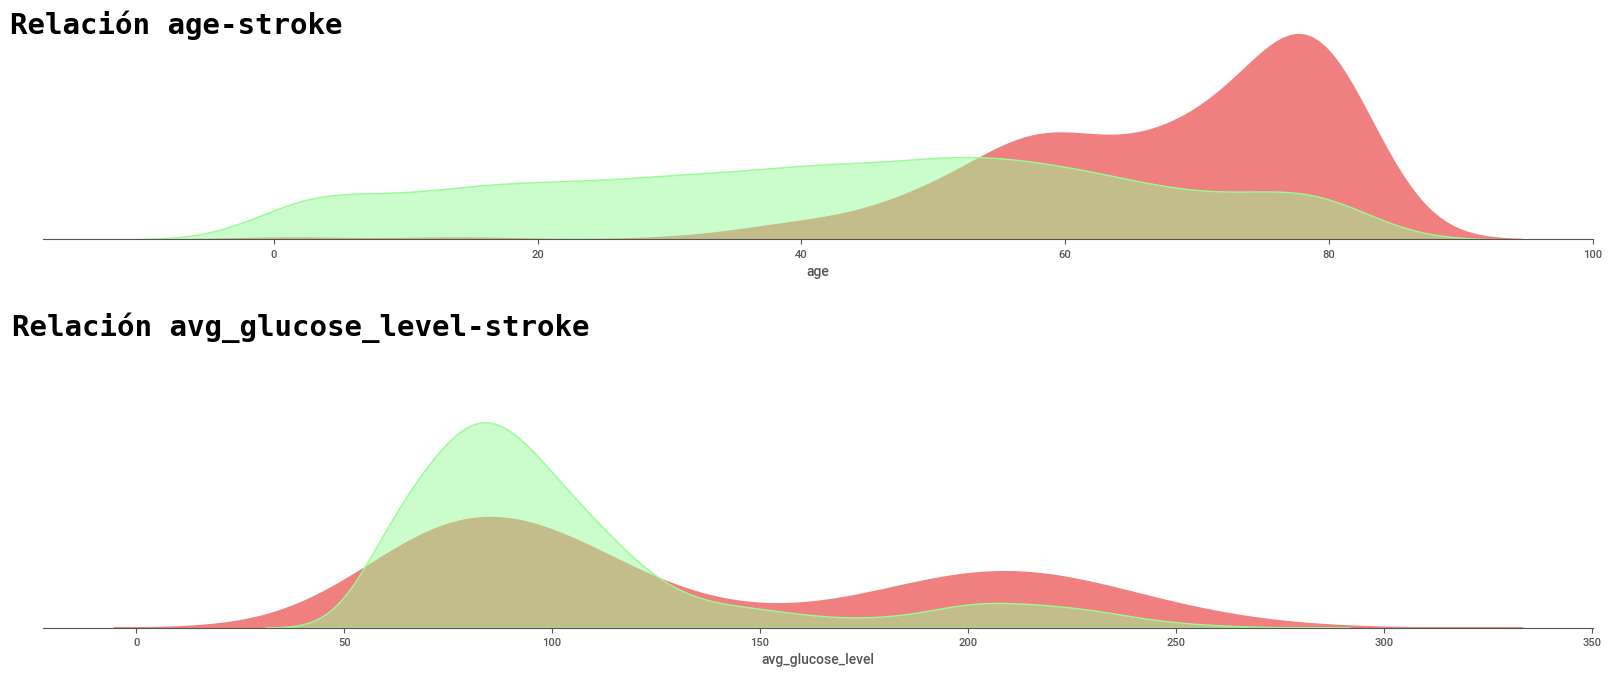

In [71]:
fig = plt.figure(figsize=(20, 8), facecolor="white")
ax = [None for i in range(2)]
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0, hspace=0.8)

ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[1, 0])

ax[0].text(
    -20,
    0.04,
    "Relación age-stroke",
    fontsize=21,
    fontweight="bold",
    fontfamily="monospace",
)
# ax[0].text(
#     -20,
#     0.035,
#     "The older a person is, the more likely he/she has a stroke",
#     fontsize=16,
#     fontweight="light",
#     fontfamily="monospace",
# )
ax[1].text(
    -30,
    0.023,
    "Relación avg_glucose_level-stroke",
    fontsize=21,
    fontweight="bold",
    fontfamily="monospace",
)
# ax[1].text(
#     -30,
#     0.0207,
#     "From this graph, there is no clear relationship between avg_glucose_level and stroke",
#     fontsize=16,
#     fontweight="light",
#     fontfamily="monospace",
# )

sns.kdeplot(
    data=df_strokes[df_strokes.stroke == 1],
    x="age",
    ax=ax[0],
    shade=True,
    color="lightcoral",
    alpha=1,
)
sns.kdeplot(
    data=df_strokes[df_strokes.stroke == 0],
    x="age",
    ax=ax[0],
    shade=True,
    color="palegreen",
    alpha=0.5,
)
sns.kdeplot(
    data=df_strokes[df_strokes.stroke == 1],
    x="avg_glucose_level",
    ax=ax[1],
    shade=True,
    color="lightcoral",
    alpha=1,
)
sns.kdeplot(
    data=df_strokes[df_strokes.stroke == 0],
    x="avg_glucose_level",
    ax=ax[1],
    shade=True,
    color="palegreen",
    alpha=0.5,
)

for i in range(2):
    ax[i].set_yticklabels("")
    ax[i].set_ylabel("")
    ax[i].tick_params(axis="y", length=0)

    for direction in ["top", "right", "left"]:
        ax[i].spines[direction].set_visible(False)

# TBD: Cambiar esto para que se vea más nuestro

In [72]:
# Ref:
# https://www.kaggle.com/bhuvanchennoju/data-stroytelling-auc-focus-on-strokes?scriptVersionId=59878979

## Conclusiones correlacion y seleccion de atributos

d) Se necesita saber cuáles son los indicadores que determinan más susceptibilidad a sufrir una lesión. ¿Qué atributos utilizará como variables predictoras? ¿Por qué?  


* Edad parece ser la que mejor correlaciona y la que más información aporta para detectar stroke
    * heart_disease, hypertension parecieran ayudar a detectar stroke
    * El árbol no las usa, o por lo menos no en primera instancia
    * TBD? Heart_disease e hypertension se correlacionan muy fuerte con edad, pareciera no aportar información nueva
* Avg_glucose_level -> Parece ser bimodal y aportar información nueva


## Balanceo

----
e) ¿Se encuentra balanceado el conjunto de datos que utilizará para desarrollar el algoritmo diseñado para contestar el punto d)? En base a lo respondido, ¿qué métricas de performance reportaría y por qué? En caso de estar desbalanceado, ¿qué estrategia de balanceo utilizaría?  


No, el dataset no se encuentra balanceado.  


In [73]:
df_strokes.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [74]:
df_strokes.stroke.value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Estrategias a utilizar para enfrentar el desbalanceo

* Metodos de sampling y under sampling
* Usar la feature del método de Sklearn que balancea el data set (Usado)
* Método SMOTE (**TBD**)

**Ref**: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

## Medidas de performance

-----
f) Suponiendo que es más importante detectar los casos en donde el evento ocurre. ¿Qué medida de performance utilizaría? Si utiliza Fβ-Score, ¿qué valor de β eligiría?  

***


### Medidas de performance

* Precision: De las instancias clasificadas como positivas, cuántas lo son (Cuán útiles son los resultados de búsqueda)
* Recall: de las instancias positivas, cuántas fueron clasificadas como positivas (Cuán completos son los resultados)

Creemos que recall es más importante, al ser un tema médico es importante cuidar la completitud de los resultados. Si alguien tiene posibilidad de tener un infarto, detectarlo y poder decir que se cuide.

El 'costo' de decirle a alguien va a sufrir un infarto pero al final no, es menor a no decirle a alguien que va a tener un infarto que no va a tenerlo.

### F-beta.

Usaríamos F1 y F2

F1 por una cuestión de generalidad, la mayoría de los métodos y librerías vienen por defecto con métricas del estilo F1, también nos parece interesante usar F2 (Porque da más peso al Recall que sería lo que queremos priorizar)

**TBD** justificación teórica del F2.

## Primer arbol

In [75]:
df_strokes.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'bmi_discretizada', 'age_discretizada',
       'glucose_discretizada', 'ever_married_cat', 'resident_type_urban',
       'gender_Female', 'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly_smoked',
       'smoking_status_never_smoked', 'smoking_status_smokes',
       'bmi_inputation_mean', 'bmi_inputation_knn',
       'bmi_inputation_work_type'],
      dtype='object')

### Drop de columnas categoricas


In [76]:
data = df_strokes.copy(deep=True)
data = data.drop(
    labels=[
        "stroke",
        "gender",
        "work_type",
        "Residence_type",
        "ever_married",
        "smoking_status",
        "bmi_inputation_mean",
        "bmi",
        "bmi_inputation_work_type",
        "id",
        "bmi_discretizada",
        "age_discretizada",
        "glucose_discretizada",
    ],
    axis=1,
)
target = df_strokes["stroke"]

data.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'ever_married_cat', 'resident_type_urban', 'gender_Female',
       'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly_smoked',
       'smoking_status_never_smoked', 'smoking_status_smokes',
       'bmi_inputation_knn'],
      dtype='object')

g) Implementar el algoritmo introducido en el punto d) utilizando árboles de decisión. En primer lugar, se deberá separar un 20% de los datos para usarlos como conjunto de evaluación (test set). El conjunto restante (80%) es el de desarrollo y es con el que se deberá continuar haciendo el trabajo. Realizar los siguientes puntos:
1) Armar conjuntos de entrenamiento y validación con proporción 80-20 del conjunto de desarrollo de forma aleatoria. Usar 50 semillas distintas y realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c) en esas 50 particiones distintas.
2) Usar validación cruzada de 50 iteraciones (50-fold cross validation). Realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en esas 50 particiones distintas.
***


### Split

In [77]:
x_train, x_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42, stratify=target.values
)

Primeros dos árboles con y sin balanceo para ver como afecta a las métricas

### Train sin balanceo

In [78]:
arbol_sklearn = tree.DecisionTreeClassifier( random_state=42
#     criterion="entropy", max_depth=5, min_samples_leaf=1, ccp_alpha=0
)
arbol_sklearn.fit(x_train, y_train)
y_pred_test = arbol_sklearn.predict(x_test)
y_pred_train = arbol_sklearn.predict(x_train)

print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test)))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1)))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2)))

print(classification_report(y_test, y_pred_test))
predictions = arbol_sklearn.predict(x_test)

Train acc: 1.0
Test acc: 0.9090019569471625
Test recall: 0.14
Test F1: 0.1308411214953271
Test F2: 0.13618677042801555
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.12      0.14      0.13        50

    accuracy                           0.91      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.91      0.91      0.91      1022



### Train con balanceo

In [79]:
arbol_sklearn = tree.DecisionTreeClassifier(#criterion="entropy",max_depth=5, min_samples_leaf=1, ccp_alpha=0,
     random_state=42,class_weight="balanced",)
arbol_sklearn.fit(x_train, y_train)
arbol_sklearn.predict(x_test)
y_pred_test = arbol_sklearn.predict(x_test)
y_pred_train = arbol_sklearn.predict(x_train)

print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test)))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1)))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2)))
print(classification_report(y_test, y_pred_test))

predictions = arbol_sklearn.predict(x_test)

Train acc: 1.0
Test acc: 0.9178082191780822
Test recall: 0.1
Test F1: 0.10638297872340427
Test F2: 0.10245901639344261
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       972
           1       0.11      0.10      0.11        50

    accuracy                           0.92      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.91      0.92      0.92      1022



### Feature importance

In [80]:
importancia_predictores = pd.DataFrame(
    {"Predictor": data.columns, "Importancia": arbol_sklearn.feature_importances_}
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("Importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


Predictor  Importancia
0                              age     0.479480
3                avg_glucose_level     0.204779
18              bmi_inputation_knn     0.190970
16     smoking_status_never_smoked     0.019282
4                 ever_married_cat     0.014568
9               work_type_Govt_job     0.011057
11               work_type_Private     0.010333
14          smoking_status_Unknown     0.009897
1                     hypertension     0.009601
7                      gender_Male     0.008748
15  smoking_status_formerly_smoked     0.007748
2                    heart_disease     0.007482
17           smoking_status_smokes     0.006913
5              resident_type_urban     0.006779
6                    gender_Female     0.006620
12         work_type_Self-employed     0.005744
8                     gender_Other     0.000000
10          work_type_Never_worked     0.000000
13              work_type_children     0.000000

## Varias semillas

 1) Armar conjuntos de entrenamiento y validación con proporción 80-20 del conjunto de desarrollo de forma aleatoria. Usar 50 semillas distintas y realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c) en esas 50 particiones distintas. 

**TBD**: Train-val-test

Comparación de métricas de dos árboles con mayor y menor alfa, utilizando un for y 50 semillas distintas 

In [81]:
all_metrics = []
metric_labels = []

In [82]:
output_accs = []
output_precisions = []
output_recalls = []
output_f1 = []
output_f2 = []

for i in range(50):

    x_train, x_test, y_train, y_test = train_test_split(
        data, target, test_size=0.2, random_state=i, stratify=target.values
    )
    arbol_sklearn = tree.DecisionTreeClassifier(
#         criterion="gini",
#         max_depth=7,
#         min_samples_leaf=5,
#         ccp_alpha=0.007537688442211055,
        random_state=42,
        class_weight="balanced",
    )
    arbol_sklearn.fit(x_train, y_train)

    y_pred_test = arbol_sklearn.predict(x_test)
    y_pred_train = arbol_sklearn.predict(x_train)

    output_accs.append(accuracy_score(y_test, y_pred_test))
    output_precisions.append(precision_score(y_test, y_pred_test))
    output_recalls.append(recall_score(y_test, y_pred_test))
    output_f1.append(fbeta_score(y_test, y_pred_test, beta=1))
    output_f2.append(fbeta_score(y_test, y_pred_test, beta=2))

all_metrics = output_accs + output_precisions + output_recalls + output_f1 + output_f2
metric_labels = (
    ["Accuracy"] * len(output_accs)
    + ["Precision"] * len(output_precisions)
    + ["Recall"] * len(output_recalls)
    + ["F1 Score"] * len(output_f1)
    + ["F2 Score"] * len(output_f2)
)

In [83]:
output_accs = []
output_precisions = []
output_recalls = []
output_f1 = []
output_f2 = []

for i in range(50):

    x_train, x_test, y_train, y_test = train_test_split(
        data, target, test_size=0.2, random_state=i, stratify=target.values
    )
    arbol_sklearn = tree.DecisionTreeClassifier(
        criterion="gini",
        max_depth=7,
        min_samples_leaf=5,
        ccp_alpha=0.002512562814070352,
        random_state=42,
        class_weight="balanced",
    )
    arbol_sklearn.fit(x_train, y_train)

    y_pred_test = arbol_sklearn.predict(x_test)
    y_pred_train = arbol_sklearn.predict(x_train)

    output_accs.append(accuracy_score(y_test, y_pred_test))
    output_precisions.append(precision_score(y_test, y_pred_test))
    output_recalls.append(recall_score(y_test, y_pred_test))
    output_f1.append(fbeta_score(y_test, y_pred_test, beta=1))
    output_f2.append(fbeta_score(y_test, y_pred_test, beta=2))


all_metrics = (
    all_metrics
    + output_accs
    + output_precisions
    + output_recalls
    + output_f1
    + output_f2
)
metric_labels = (
    metric_labels
    + ["Accuracy"] * len(output_accs)
    + ["Precision"] * len(output_precisions)
    + ["Recall"] * len(output_recalls)
    + ["F1 Score"] * len(output_f1)
    + ["F2 Score"] * len(output_f2)
)

In [84]:
len(all_metrics)

500

/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

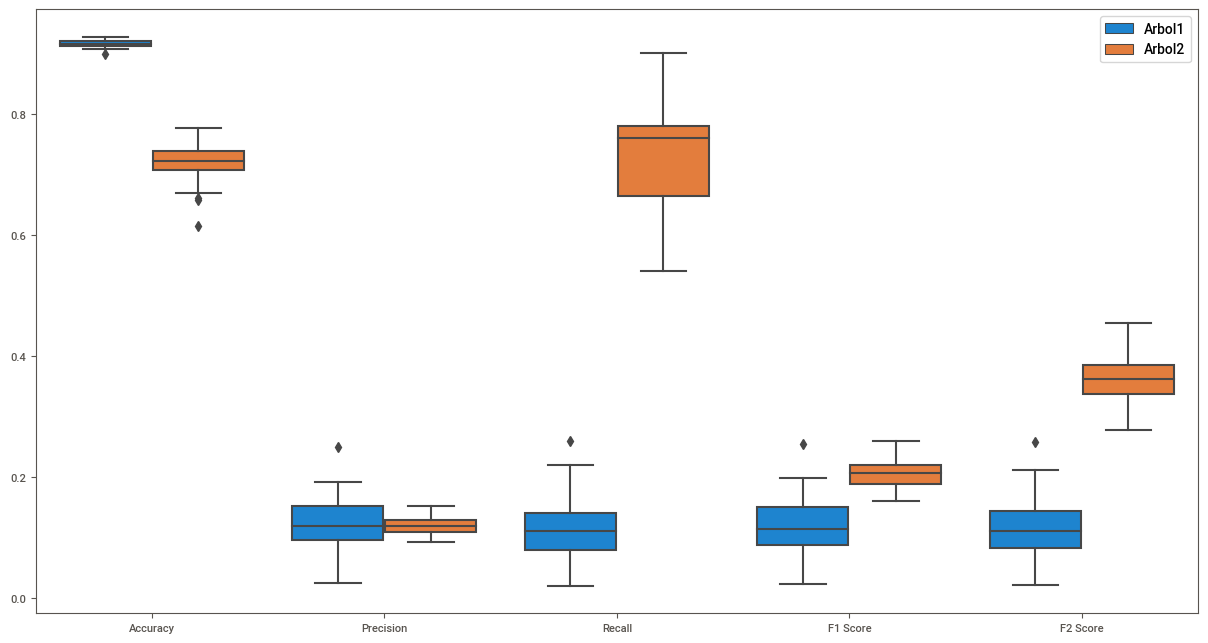

In [85]:
hue = ["Arbol1"] * 250 + ["Arbol2"] * 250
plt.figure(figsize=(15, 8))
sns.boxplot(metric_labels, all_metrics, hue=hue)

## Kfolds

2) Usar validación cruzada de 50 iteraciones (50-fold cross validation). Realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en esas 50 particiones distintas.

In [86]:
clf = tree.DecisionTreeClassifier(
    criterion="gini",
    max_depth=7,
    min_samples_leaf=5,
    ccp_alpha=0.002512562814070352,
    random_state=42,
    class_weight="balanced",
)
# clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1, ccp_alpha=0, class_weight="balanced" )
# Perform 7-fold cross validation
scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4)

### Algunas métricas

Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

**TBD**: mejorar estos gráficos, juntarlos como en el caso de arriba

In [87]:
all_metrics = []
metric_labels = []

In [88]:
output_accs = []
output_precisions = []
output_recalls = []
output_f1 = []
output_f2 = []

for i in range(50):

    x_train, x_test, y_train, y_test = train_test_split(
        data, target, test_size=0.2, random_state=i, stratify=target.values
    )
#     arbol_sklearn = tree.DecisionTreeClassifier(
#         criterion="gini",
#         max_depth=7,
#         min_samples_leaf=5,
#         ccp_alpha=0.002512562814070352,
#         random_state=42,
#         class_weight="balanced",
#     )
    clf.fit(x_train, y_train)

    y_pred_test = clf.predict(x_test)
    y_pred_train = clf.predict(x_train)

    output_accs.append(accuracy_score(y_test, y_pred_test))
    output_precisions.append(precision_score(y_test, y_pred_test))
    output_recalls.append(recall_score(y_test, y_pred_test))
    output_f1.append(fbeta_score(y_test, y_pred_test, beta=1))
    output_f2.append(fbeta_score(y_test, y_pred_test, beta=2))

all_metrics = output_accs + output_precisions + output_recalls + output_f1 + output_f2
metric_labels = (
    ["Accuracy"] * len(output_accs)
    + ["Precision"] * len(output_precisions)
    + ["Recall"] * len(output_recalls)
    + ["F1 Score"] * len(output_f1)
    + ["F2 Score"] * len(output_f2)
)

In [89]:
output_accs = []
output_precisions = []
output_recalls = []
output_f1 = []
output_f2 = []

output_accs = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4)
output_precisions = cross_val_score(
    estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring="precision"
)
output_recalls = cross_val_score(
    estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring="recall"
)
output_f1 = cross_val_score(
    estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring="f1"
)
output_f2.append(
    cross_val_score(
        estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring=scorer_f2
    )
)


all_metrics = (
    all_metrics
    + list(output_accs)
    + list(output_precisions)
    + list(output_recalls)
    + list(output_f1)
    + list(output_f2[0])
)
metric_labels = (
    metric_labels
    + ["Accuracy"] * len(output_accs)
    + ["Precision"] * len(output_precisions)
    + ["Recall"] * len(output_recalls)
    + ["F1 Score"] * len(output_f1)
    + ["F2 Score"] * len(output_f2[0])
)

In [90]:
len(all_metrics)
# all_metrics

500

/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

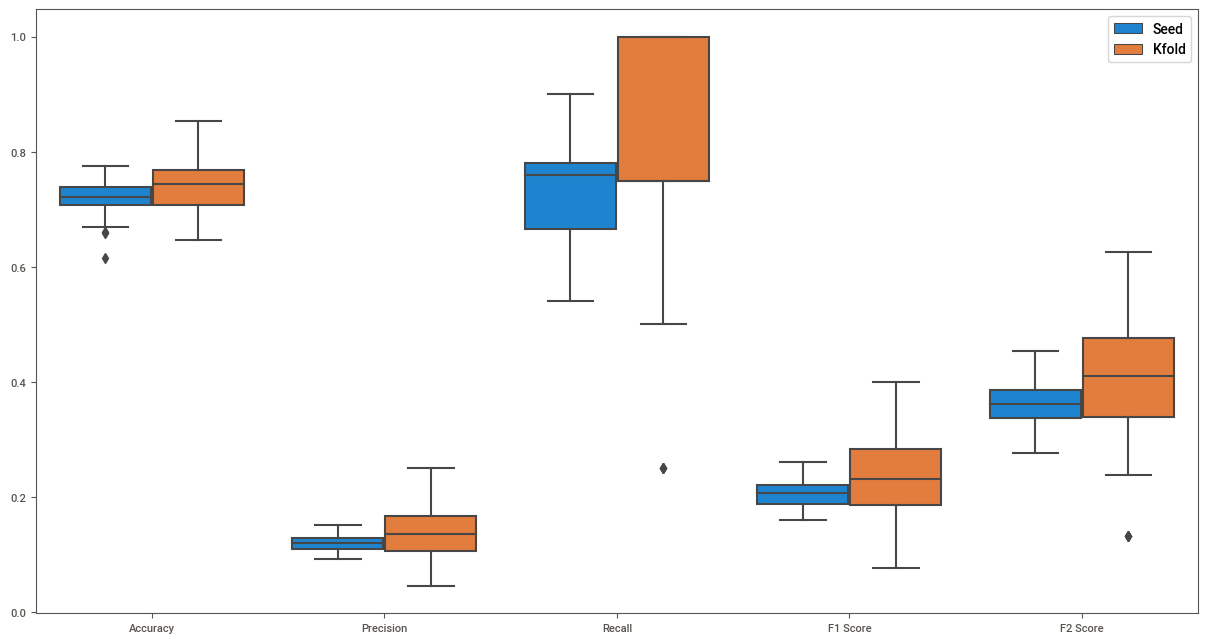

In [91]:
hue = ["Seed"] * 250 + ["Kfold"] * 250
plt.figure(figsize=(15, 8))
sns.boxplot(metric_labels, all_metrics, hue=hue)

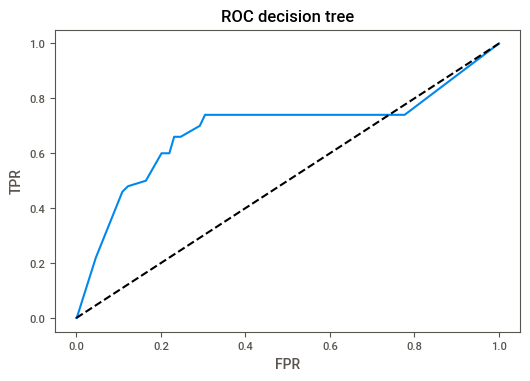

In [92]:
clf.fit(x_train, y_train)

y_pred_test = clf.predict(x_test)
y_pred_train = clf.predict(x_train)

y_scores = clf.predict_proba(x_test)
out_probs = y_scores[:,1]

fpr, tpr, th = roc_curve(y_test, out_probs)

plt.title("ROC decision tree")
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr, fpr, "--k")

0.78 accuracy with a standard deviation of 0.13


<AxesSubplot:>

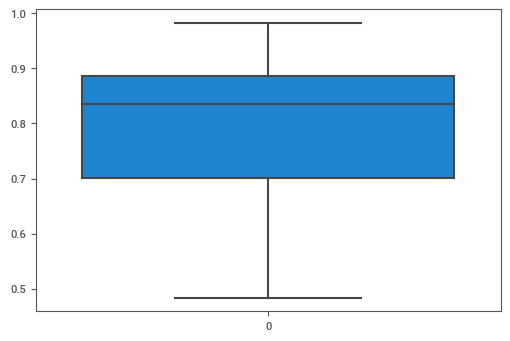

In [93]:
# TBD: mejorar este gráfico de roc_auc
scores = cross_val_score(
    estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring="roc_auc"
)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)
sns.boxplot(data=scores)

### SMOTE

In [94]:
data.dtypes

age                                float64
hypertension                      category
heart_disease                     category
avg_glucose_level                  float64
ever_married_cat                      int8
resident_type_urban                   int8
gender_Female                      float64
gender_Male                        float64
gender_Other                       float64
work_type_Govt_job                 float64
work_type_Never_worked             float64
work_type_Private                  float64
work_type_Self-employed            float64
work_type_children                 float64
smoking_status_Unknown             float64
smoking_status_formerly_smoked     float64
smoking_status_never_smoked        float64
smoking_status_smokes              float64
bmi_inputation_knn                 float64
dtype: object

In [95]:
# Casteo por un problema en el tipo de datos que complicaba a SMOTE
for i in [
            "age",
            "hypertension",
            "heart_disease",
            "avg_glucose_level",
            "ever_married_cat",
            "resident_type_urban",
            "gender_Female",
            "gender_Male",
            "gender_Other",
            "work_type_Govt_job",
            "work_type_Never_worked",
            "work_type_Private",
            "work_type_Self-employed",
            "work_type_children",
            "smoking_status_Unknown",
            "smoking_status_formerly_smoked",
            "smoking_status_never_smoked",
            "smoking_status_smokes",
            "bmi_inputation_knn",
        ]:
    data[i] = data[i].astype("float32")    

In [96]:
x_smote_train, x_smote_test, y_smote_train, y_smote_test = train_test_split(
    data[
        [
            "age",
            "hypertension",
            "heart_disease",
            "avg_glucose_level",
            "ever_married_cat",
            "resident_type_urban",
            "gender_Female",
            "gender_Male",
            "gender_Other",
            "work_type_Govt_job",
            "work_type_Never_worked",
            "work_type_Private",
            "work_type_Self-employed",
            "work_type_children",
            "smoking_status_Unknown",
            "smoking_status_formerly_smoked",
            "smoking_status_never_smoked",
            "smoking_status_smokes",
            "bmi_inputation_knn",
        ]
    ],
    target,
    test_size=0.20,
    random_state=42,
)

sm = SMOTE(random_state=42, sampling_strategy=0.25)
x_smote_train, y_smote_train = sm.fit_resample(x_smote_train, y_smote_train)

In [97]:
x_smote_train.count()

age                               4876
hypertension                      4876
heart_disease                     4876
avg_glucose_level                 4876
ever_married_cat                  4876
resident_type_urban               4876
gender_Female                     4876
gender_Male                       4876
gender_Other                      4876
work_type_Govt_job                4876
work_type_Never_worked            4876
work_type_Private                 4876
work_type_Self-employed           4876
work_type_children                4876
smoking_status_Unknown            4876
smoking_status_formerly_smoked    4876
smoking_status_never_smoked       4876
smoking_status_smokes             4876
bmi_inputation_knn                4876
dtype: int64

In [98]:
y_smote_train.value_counts()

0    3901
1     975
Name: stroke, dtype: int64

In [99]:
smote_model = tree.DecisionTreeClassifier(
    criterion="gini",
    max_depth=7,
    min_samples_leaf=5,
    ccp_alpha=0.002512562814070352,
    class_weight="balanced",
)
smote = smote_model.fit(x_smote_train, y_smote_train)
y_smote_pred_test = smote.predict(x_smote_test)
y_smote_pred_train = smote.predict(x_smote_train)

In [100]:
print("Train acc: {}".format(accuracy_score(y_smote_train, y_smote_pred_train)))
print("Test acc: {}".format(accuracy_score(y_smote_test, y_smote_pred_test)))
print("Test recall: {}".format(recall_score(y_smote_test, y_smote_pred_test)))
print("Test F1: {}".format(fbeta_score(y_smote_test, y_smote_pred_test, beta=1)))
print("Test F2: {}".format(fbeta_score(y_smote_test, y_smote_pred_test, beta=2)))
print(classification_report(y_smote_test, y_pred_test))

Train acc: 0.8506972928630024
Test acc: 0.812133072407045
Test recall: 0.5806451612903226
Test F1: 0.2727272727272727
Test F2: 0.3999999999999999
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       960
           1       0.05      0.24      0.08        62

    accuracy                           0.66      1022
   macro avg       0.49      0.46      0.43      1022
weighted avg       0.88      0.66      0.75      1022



In [101]:
output_accs = cross_val_score(
    estimator=smote_model, X=x_smote_train, y=y_smote_train, cv=50, n_jobs=4
)
output_precisions = cross_val_score(
    estimator=smote_model,
    X=x_smote_train,
    y=y_smote_train,
    cv=50,
    n_jobs=4,
    scoring="precision",
)
output_recalls = cross_val_score(
    estimator=smote_model,
    X=x_smote_train,
    y=y_smote_train,
    cv=50,
    n_jobs=4,
    scoring="recall",
)
output_f1 = cross_val_score(
    estimator=smote_model,
    X=x_smote_train,
    y=y_smote_train,
    cv=50,
    n_jobs=4,
    scoring="f1",
)
output_f2 = cross_val_score(
    estimator=smote_model,
    X=x_smote_train,
    y=y_smote_train,
    cv=50,
    n_jobs=4,
    scoring=scorer_f2,
)


all_metrics = (
    all_metrics
    + list(output_accs)
    + list(output_precisions)
    + list(output_recalls)
    + list(output_f1)
    + list(output_f2)
)
metric_labels = (
    metric_labels
    + ["Accuracy"] * len(output_accs)
    + ["Precision"] * len(output_precisions)
    + ["Recall"] * len(output_recalls)
    + ["F1 Score"] * len(output_f1)
    + ["F2 Score"] * len(output_f2)
)

/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

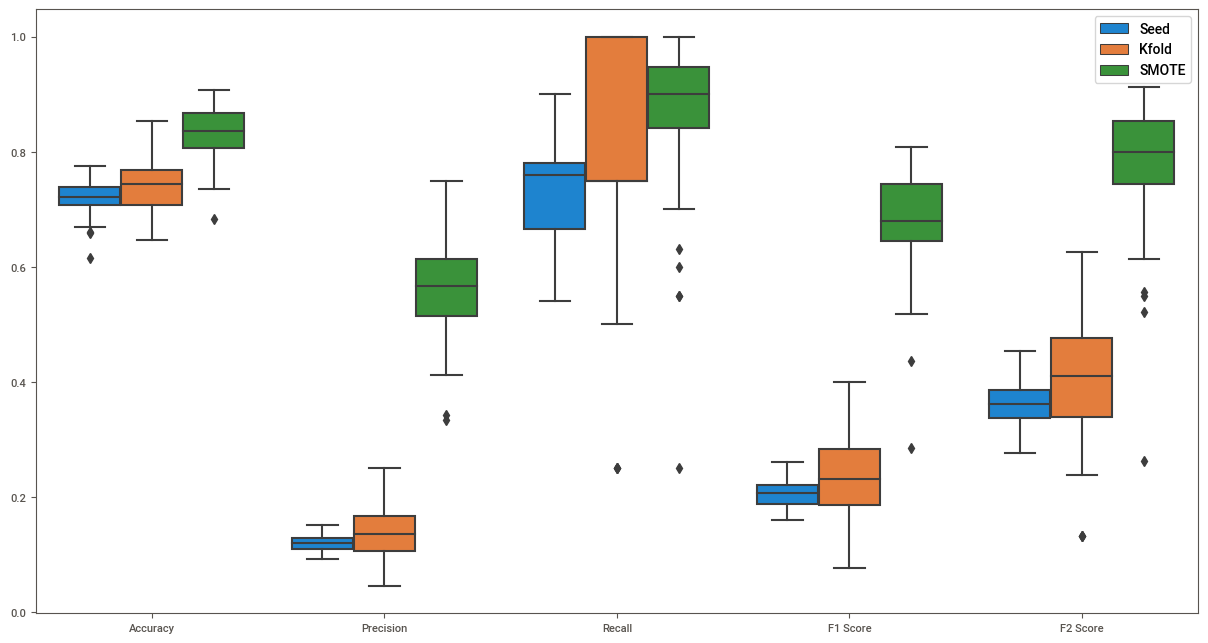

In [102]:
hue = ["Seed"] * 250 + ["Kfold"] * 250 + ["SMOTE"] * 250
plt.figure(figsize=(15, 8))
sns.boxplot(metric_labels, all_metrics, hue=hue)

Text(49.722222222222214, 0.5, 'True')

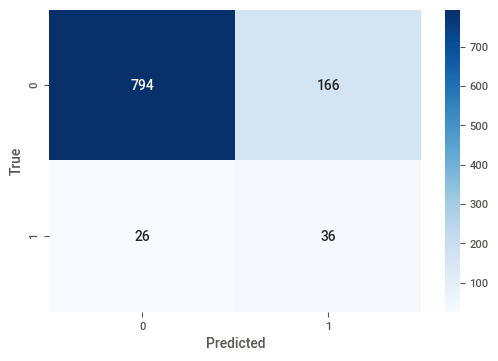

In [135]:
cm = confusion_matrix(y_smote_test, y_smote_pred_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")

## Búsqueda de parámetros

x_train, x_test, y_train, y_test 

### Cantidad parametros

Podemos usar el logaritmo en base de dos de la cantidad de datos que tenemos para poder estimar la profundidad a partir de la cual overfiteamos el árbol.

**TBD** (Buscar tambien teoría que respalde)


In [103]:
# 2 ^ n < Cant de datos
math.log2(5110)

12.319107575824983

In [104]:
# Cantidad combinaciones
print(2 * 12 * 200 * 4)

19200


### Grid search

Sección de búsqueda de hiperparámetros. 

En la grilla de parametros están posibles valores de los hiperparámetros para que el método RandomizedSearchCV o GridSearchCV, busqué dentro de ese espacio.

Además colocamos la métrica f2 para optimizar la búsqueda, alineado a lo que venimos plantenado.

* La profundidad máxima fue 13 => Intentando minimizar la chance de overfitting
* El alfa hasta 0.01 => Intentando no tener una poda muy agresiva 
    * Esto se puede ver mejor con los gráficos del final (Referencia)
* min_samples_leaf entre 2 y 30. 

**tbd** contar mejor las iteraciones.
Empezamos con depth (1,12) => (1,30) => (1,13)
Empezamos con ccp_alpha (0, 0.1) => (0, 0.01)

Encontramos árboles de lo más diverso. 
* Alpha 0
* Profundida 19 y alfa 0.01 => Quedaba en 7 niveles. 

Buscar 2 o 3 casos curiosos y mencionarlos.

Como mostrar el avance del método de búsqueda. Verbose=1 o verbose=10. Mayor el número más info devuelve, y evitamos pensar que el método no está haciendo nada cuando está trabajando.

https://stackoverflow.com/questions/24121018/sklearn-gridsearch-how-to-print-out-progress-during-the-execution

In [105]:
start = time.time()
# Uno podría pasar una distribución para la busqueda de hiperparámetros
# Ref de criterios -> https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
params_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(1, 13)),
    "ccp_alpha": np.linspace(0, 0.01, 200),
    "min_samples_leaf": list(range(2, 30)),
    # cuantas muestras en nodo para poder hacer el split -> https://youtu.be/XABw4Y3GBR4?t=260
    # 'min_samples_split': list(range(2,6))
}

kfoldcv = StratifiedKFold(n_splits=50)
base_tree = DecisionTreeClassifier(class_weight="balanced")
# F1 score
# scorer_fn = make_scorer(f1_score)
# F2 score
scorer_f2 = make_scorer(fbeta_score, beta=2)
randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=params_grid,
    scoring=scorer_f2,
    cv=kfoldcv,
    n_iter=2,
    verbose=10,
)
# randomcv = GridSearchCV(
#     estimator=base_tree,
#     param_grid=params_grid,
#     scoring=scorer_f2,
#     cv=kfoldcv,
#     random_state=42,
#     verbose=10,
# )
randomcv.fit(x_train, y_train)

end = time.time()
# TBD: Busqueda bayesiana, que use gradiente ( Algo que habían compartido Joaquin y Lucas )

Fitting 50 folds for each of 2 candidates, totalling 100 fits
[CV 1/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 1/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.513 total time=   0.0s
[CV 2/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 2/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.500 total time=   0.0s
[CV 3/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 3/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.606 total time=   0.0s
[CV 4/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 4/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.375 total tim

[CV 41/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.500 total time=   0.0s
[CV 42/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 42/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.417 total time=   0.0s
[CV 43/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 43/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.526 total time=   0.0s
[CV 44/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 44/50; 1/2] END ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10;, score=0.323 total time=   0.0s
[CV 45/50; 1/2] START ccp_alpha=0.008040201005025126, criterion=gini, max_depth=12, min_samples_leaf=10
[CV 45/50; 1/2] END ccp_alpha=0.008040201005

[CV 26/50; 2/2] END ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21;, score=0.294 total time=   0.0s
[CV 27/50; 2/2] START ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21
[CV 27/50; 2/2] END ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21;, score=0.488 total time=   0.0s
[CV 28/50; 2/2] START ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21
[CV 28/50; 2/2] END ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21;, score=0.385 total time=   0.0s
[CV 29/50; 2/2] START ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21
[CV 29/50; 2/2] END ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21;, score=0.349 total time=   0.0s
[CV 30/50; 2/2] START ccp_alpha=0.00914572864321608, criterion=gini, max_depth=1, min_samples_leaf=21
[CV 30/50; 2/2] END ccp_alpha=0.00914572864321608, criterion

In [106]:
# Tiempo de búsqueda de hiperparámetros
print(f"Tiempo: { round(end - start, 2) } segundos")

Tiempo: 1.52 segundos


In [107]:
#Visualizar las opciones que nos devolvió
pd.DataFrame(randomcv.cv_results_).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.014929      0.002642         0.004091        0.001092   
1       0.006285      0.000606         0.003332        0.000549   

  param_min_samples_leaf param_max_depth param_criterion param_ccp_alpha  \
0                     10              12            gini       0.0080402   
1                     21               1            gini      0.00914573   

                                              params  split0_test_score  ...  \
0  {'min_samples_leaf': 10, 'max_depth': 12, 'cri...           0.512821  ...   
1  {'min_samples_leaf': 21, 'max_depth': 1, 'crit...           0.408163  ...   

   split43_test_score  split44_test_score  split45_test_score  \
0            0.322581            0.555556            0.135135   
1            0.204082            0.416667            0.384615   

   split46_test_score  split47_test_score  split48_test_score  \
0            0.344828            0.384615            0.384615   
1            0.434783            0.319149            0.476190   

   split49_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.172414         0.409871        0.119803                1  
1            0.227273         0.382442        0.069332                2  

[2 rows x 62 columns]

In [108]:
# Explorar la columnas para registrarlas en mlflow
aux = pd.DataFrame(randomcv.cv_results_)
params = [x for x in aux.columns if "param_" in x]
print(params)
score = [x for x in aux.columns if "score" in x]
print(score)
col_time = [x for x in aux.columns if "time" in x]
print(time)

['param_min_samples_leaf', 'param_max_depth', 'param_criterion', 'param_ccp_alpha']
['mean_score_time', 'std_score_time', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'split10_test_score', 'split11_test_score', 'split12_test_score', 'split13_test_score', 'split14_test_score', 'split15_test_score', 'split16_test_score', 'split17_test_score', 'split18_test_score', 'split19_test_score', 'split20_test_score', 'split21_test_score', 'split22_test_score', 'split23_test_score', 'split24_test_score', 'split25_test_score', 'split26_test_score', 'split27_test_score', 'split28_test_score', 'split29_test_score', 'split30_test_score', 'split31_test_score', 'split32_test_score', 'split33_test_score', 'split34_test_score', 'split35_test_score', 'split36_test_score', 'split37_test_score', 'split38_test_score', 'split39_test_score', 'split40

In [109]:
# Registro y versionado de modelo en mlflow
#   Comentar en caso de no estar utilizandolo

# start = time.time()
# for index, row in aux.iterrows():
#     with mlflow.start_run(experiment):
#         mlflow.log_param('Busqueda', 'RandomizedSearchCV')
#         for i in params:
#             # rint('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_param(i, row[i])

#         for i in score:
#             # rint('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])

#         for i in col_time:
#             # rint('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])
# end = time.time()
# print(f"Tiempo: { end - start }")

In [110]:
# Mejor modelo de la búsqueda
randomcv.best_params_

{'min_samples_leaf': 10,
 'max_depth': 12,
 'criterion': 'gini',
 'ccp_alpha': 0.008040201005025126}

In [111]:
# Reporte de clasificación
best_model = randomcv.best_estimator_
y_pred = best_model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       972
           1       0.14      0.60      0.23        50

    accuracy                           0.80      1022
   macro avg       0.56      0.71      0.56      1022
weighted avg       0.93      0.80      0.86      1022



## Graficar el arbol de decisión con mejor performance

Nos quedamos con la mejor versión de la búsqueda de hiperparámetros. Para la continuidad del notebook, la búsqueda de hiperparametros está 'parada' tiene solo dos, y a partir de aquí continuamos con los mejores hiperparámetros encontrados hasta el momento.


{'min_samples_leaf': 7,
 'max_depth': 5,
 'criterion': 'gini',
 'ccp_alpha': 0.002512562814070352}

In [112]:
x_train, x_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42, stratify=target.values
)
best_model = tree.DecisionTreeClassifier(
    criterion="gini",
    max_depth=7,
    min_samples_leaf=5,
    ccp_alpha=0.002512562814070352,
    class_weight="balanced",
)

best_model.fit(x_train, y_train)
y_pred_test = best_model.predict(x_test)
y_pred_train = best_model.predict(x_train)

print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test)))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1)))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2)))
print(classification_report(y_test, y_pred_test))

predictions = best_model.predict(x_test)

Train acc: 0.7152641878669276
Test acc: 0.7035225048923679
Test recall: 0.74
Test F1: 0.19628647214854109
Test F2: 0.35104364326375714
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       972
           1       0.11      0.74      0.20        50

    accuracy                           0.70      1022
   macro avg       0.55      0.72      0.51      1022
weighted avg       0.94      0.70      0.79      1022



Text(49.722222222222214, 0.5, 'True')

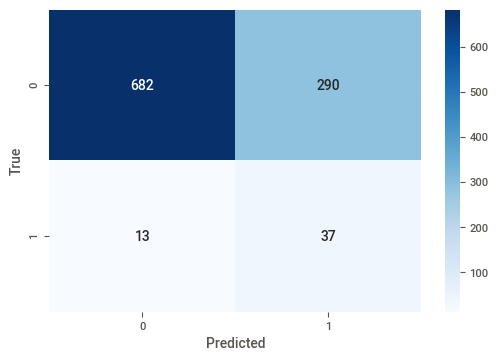

In [113]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")

In [114]:
# best_tree = randomcv.best_estimator_
feat_imps = best_model.feature_importances_
feat_imps

array([0.79471171, 0.        , 0.00649723, 0.08426581, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01132231,
       0.        , 0.01540296, 0.        , 0.        , 0.        ,
       0.        , 0.01466598, 0.        , 0.073134  ])

(Faltan traer cosas y ordenarlo)

/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


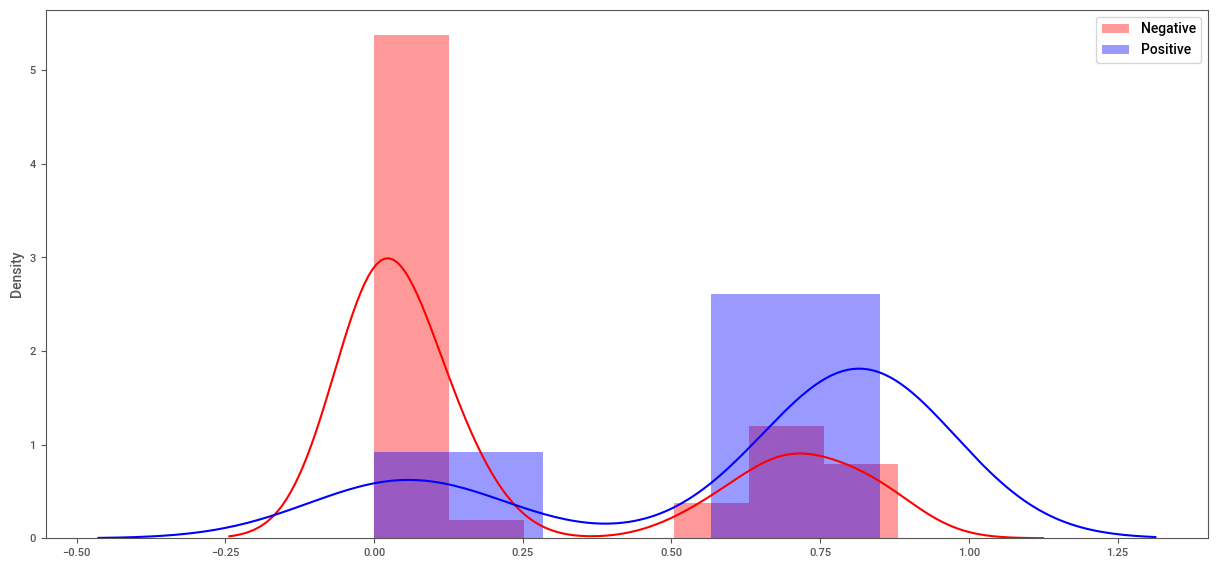

In [115]:
y_scores = best_model.predict_proba(x_test)
out_probs = y_scores[:, 1]

plt.figure(figsize=(15, 7))
sns.distplot(out_probs[y_test == 0], color="r", label="Negative")
sns.distplot(out_probs[y_test == 1], color="b", label="Positive")
plt.legend()

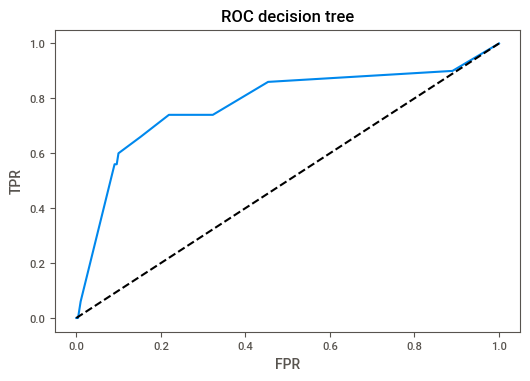

In [116]:
fpr, tpr, th = roc_curve(y_test, out_probs)

plt.title("ROC decision tree")
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr, fpr, "--k")

(0.0, 1.0)

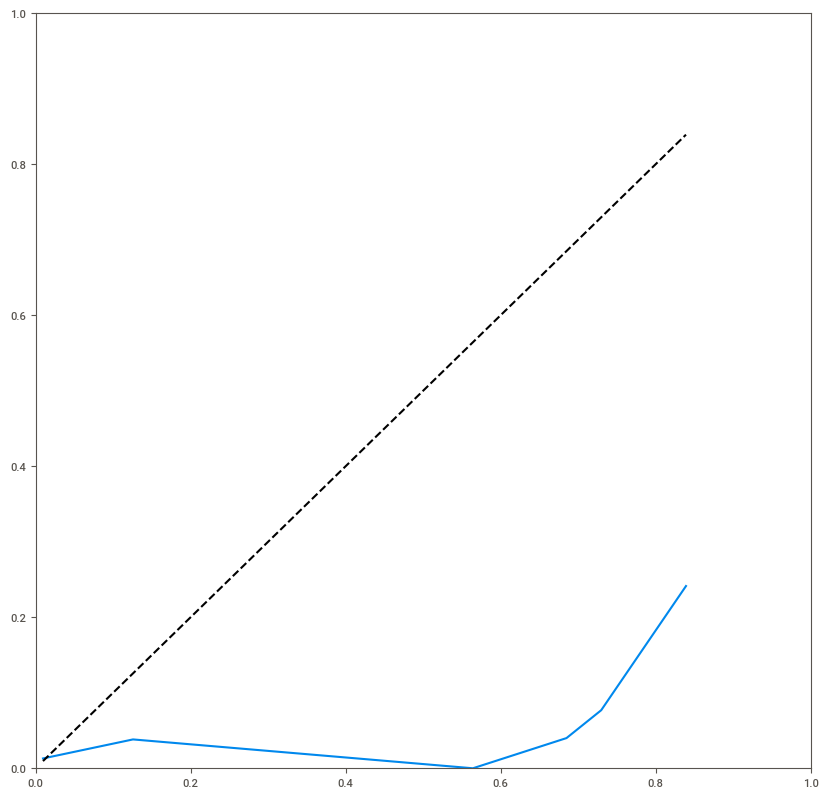

In [117]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,out_probs,n_bins=10)
plt.figure(figsize=(10,10))
plt.plot(mean_predicted_value,fraction_of_positives)
plt.plot(mean_predicted_value,mean_predicted_value,'k--')
plt.ylim(0,1)
plt.xlim(0,1)

h) Graficar el árbol de decisión con mejor performance encontrado en el punto g2). Analizar el árbol de decisión armado (atributos elegidos y decisiones evaluadas).
***


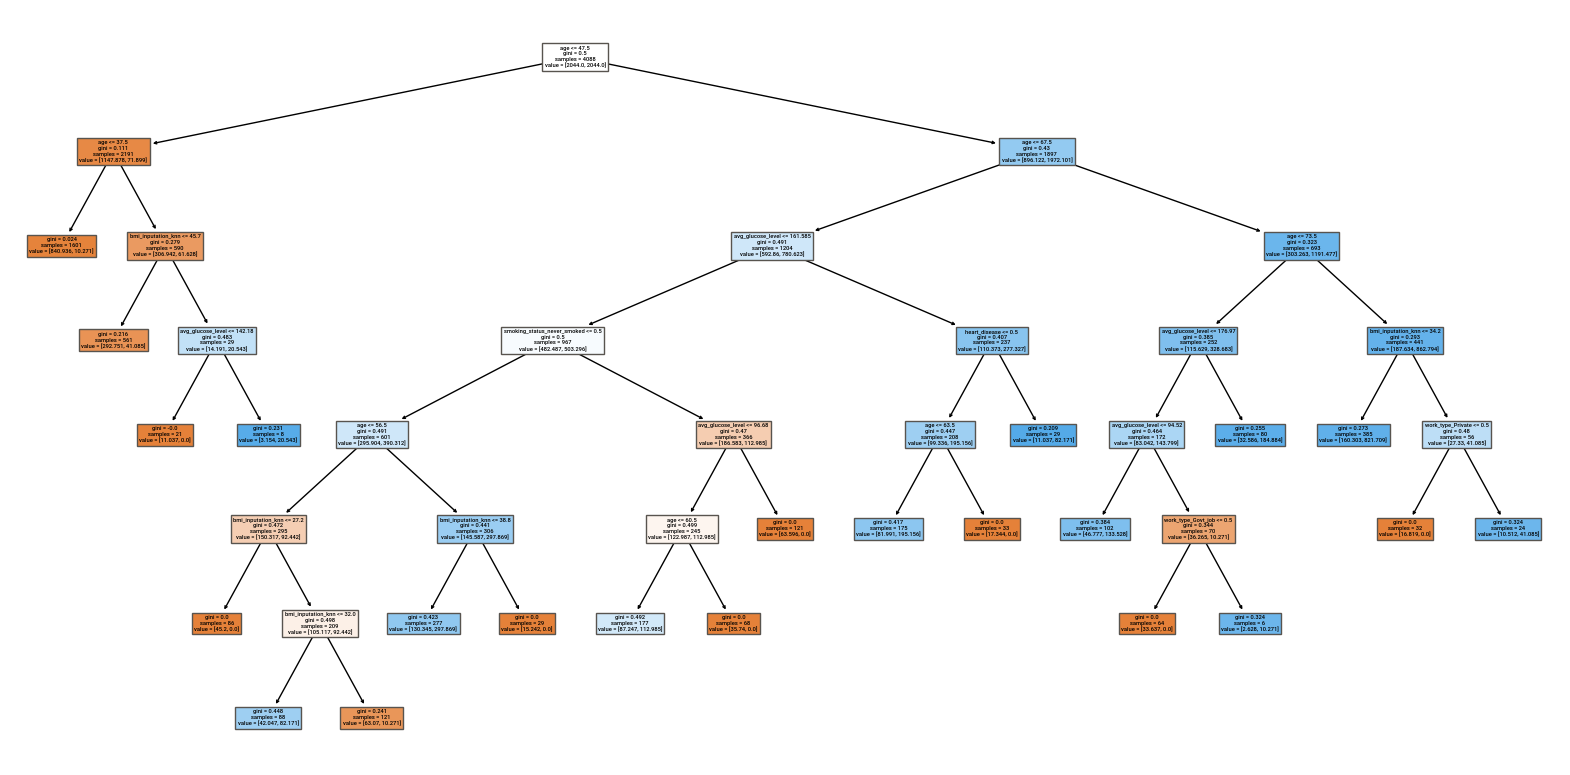

In [118]:
fig = plt.figure(figsize=(20, 10))
featnames = data.columns
plot_tree(
    best_model, feature_names=featnames, filled=True, proportion=False, impurity=True
)

fig.savefig(
    "{0}.decistion_tree.png".format(datetime.datetime.now().strftime("%Y-%m-%d.%H:%M"))
)

# Que es value? Tiene que ver con el rango, pero al estar desbalanceado
#    pondera por el peso y ajusta el rango así (O algo así nos comentó leo)

**Gini**: 
Es decir, la función toma valores próximos a cero cuando la proporción p de una clase es muy pequeña (lo que implica que el conjunto de valores está muy ordenado, pues si hay pocos elementos de la clase considerada significa que hay muchos de las demás clases) o cuando es muy grande (lo que implica, nuevamente, que hay pocos elementos de las demás clases y que el conjunto está muy ordenado).

El valor máximo de la función anterior se alcanza cuando la proporción es 0.25, lo que implica que, en un escenario con dos clases, el valor máximo del índice de Gini será de 0.5 (0.25 aportado por la primera clase más 0.25 aportado por la segunda clase).

En 0.5 es como tirar una moneda al aire. 0 y 1, es completamente pura.

In [119]:
text_representation = tree.export_text(decision_tree=best_model, feature_names=list(data.columns))
print(text_representation)

# Más info para visualizaciones: https://mljar.com/blog/visualize-decision-tree/

|--- age <= 47.50
|   |--- age <= 37.50
|   |   |--- class: 0
|   |--- age >  37.50
|   |   |--- bmi_inputation_knn <= 45.70
|   |   |   |--- class: 0
|   |   |--- bmi_inputation_knn >  45.70
|   |   |   |--- avg_glucose_level <= 142.18
|   |   |   |   |--- class: 0
|   |   |   |--- avg_glucose_level >  142.18
|   |   |   |   |--- class: 1
|--- age >  47.50
|   |--- age <= 67.50
|   |   |--- avg_glucose_level <= 161.58
|   |   |   |--- smoking_status_never_smoked <= 0.50
|   |   |   |   |--- age <= 56.50
|   |   |   |   |   |--- bmi_inputation_knn <= 27.20
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- bmi_inputation_knn >  27.20
|   |   |   |   |   |   |--- bmi_inputation_knn <= 32.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- bmi_inputation_knn >  32.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  56.50
|   |   |   |   |   |--- bmi_inputation_knn <= 38.80
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--

In [120]:
# Feature importance

importancia_predictores = pd.DataFrame(
    {"Predictor": data.columns, "Importancia": best_model.feature_importances_}
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("Importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


Predictor  Importancia
0                              age     0.794712
3                avg_glucose_level     0.084266
18              bmi_inputation_knn     0.073134
11               work_type_Private     0.015403
16     smoking_status_never_smoked     0.014666
9               work_type_Govt_job     0.011322
2                    heart_disease     0.006497
4                 ever_married_cat     0.000000
5              resident_type_urban     0.000000
6                    gender_Female     0.000000
7                      gender_Male     0.000000
8                     gender_Other     0.000000
1                     hypertension     0.000000
10          work_type_Never_worked     0.000000
12         work_type_Self-employed     0.000000
13              work_type_children     0.000000
14          smoking_status_Unknown     0.000000
15  smoking_status_formerly_smoked     0.000000
17           smoking_status_smokes     0.000000

## Distintos alfas

Con 10-folds cross validation

i) Usando validación cruzada de 10 iteraciones (10-fold cross validation), probar distintos valores de α del algoritmo de poda mínima de complejidad de costos (algoritmo de poda de sklearn). Hacer gráficos de la performance en validación y entrenamiento en función del α. Explicar cómo varía la profundidad de los árboles al realizar la poda con distintos valores de α.

**ref**: https://scikit-learn.org/dev/auto_examples/tree/plot_cost_complexity_pruning.html


In [121]:
path = best_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Impureza vs alfa usado en el set de entrenamiento')

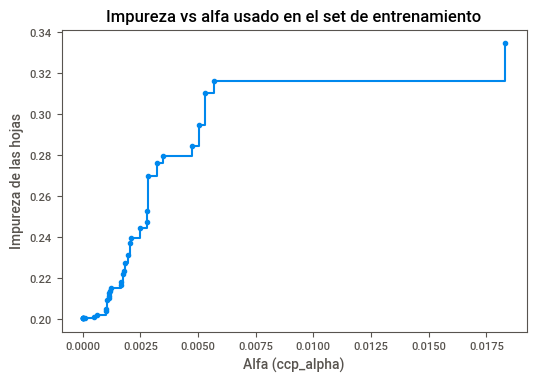

In [122]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Alfa (ccp_alpha)")
ax.set_ylabel("Impureza de las hojas")
ax.set_title("Impureza vs alfa usado en el set de entrenamiento")

In [123]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print(
    "Cantidad de nodos en el último árbol: {} con ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Cantidad de nodos en el último árbol: 1 con ccp_alpha: 0.16545637242772032


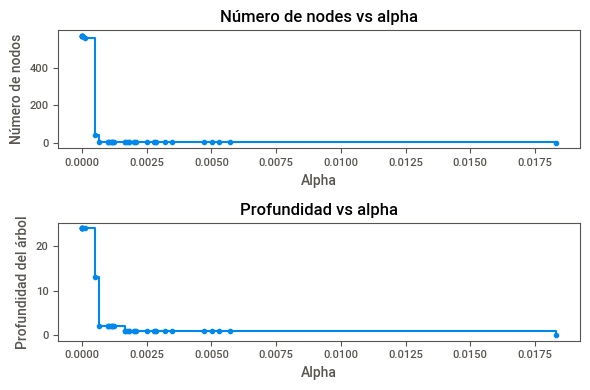

In [124]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Número de nodos")
ax[0].set_title("Número de nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Profundidad del árbol")
ax[1].set_title("Profundidad vs alpha")
fig.tight_layout()

**TBD**

For i in range(0, 0.1, 10):
    10 k-fold validation con alfa = i
    
Registrar profundidad, leaf, nodes
   

j) Evaluar en el conjunto de evaluación, el árbol correspondiente al α que maximice la performance en el conjunto de validación. Comparar con el caso sin poda (α=0)
***


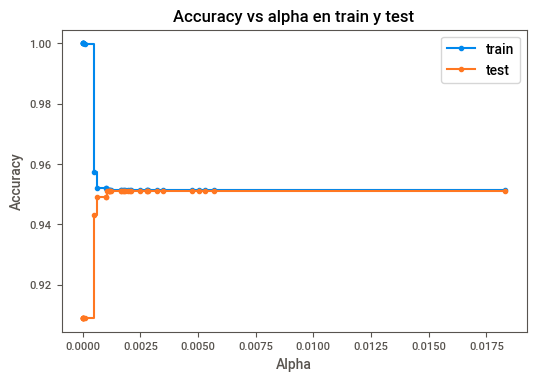

In [125]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha en train y test")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

#### Arbol sin poda

In [126]:
x_train, x_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42, stratify=target.values
)
model_sin_poda = tree.DecisionTreeClassifier(
    criterion="gini",
#     max_depth=7,
    min_samples_leaf=5,
#     ccp_alpha=0.002512562814070352,
    ccp_alpha=0.0,
    class_weight="balanced",
)

model_sin_poda.fit(x_train, y_train)
y_pred_test = model_sin_poda.predict(x_test)
y_pred_train = model_sin_poda.predict(x_train)

print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test)))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1)))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2)))
print(classification_report(y_test, y_pred_test))

predictions = best_model.predict(x_test)

Train acc: 0.9134050880626223
Test acc: 0.8512720156555773
Test recall: 0.28
Test F1: 0.15555555555555556
Test F2: 0.21212121212121215
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       972
           1       0.11      0.28      0.16        50

    accuracy                           0.85      1022
   macro avg       0.53      0.58      0.54      1022
weighted avg       0.92      0.85      0.88      1022



Text(49.722222222222214, 0.5, 'True')

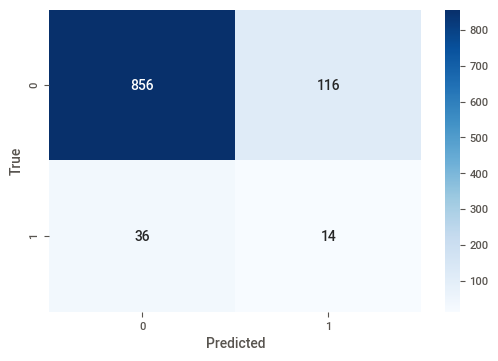

In [127]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")

/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


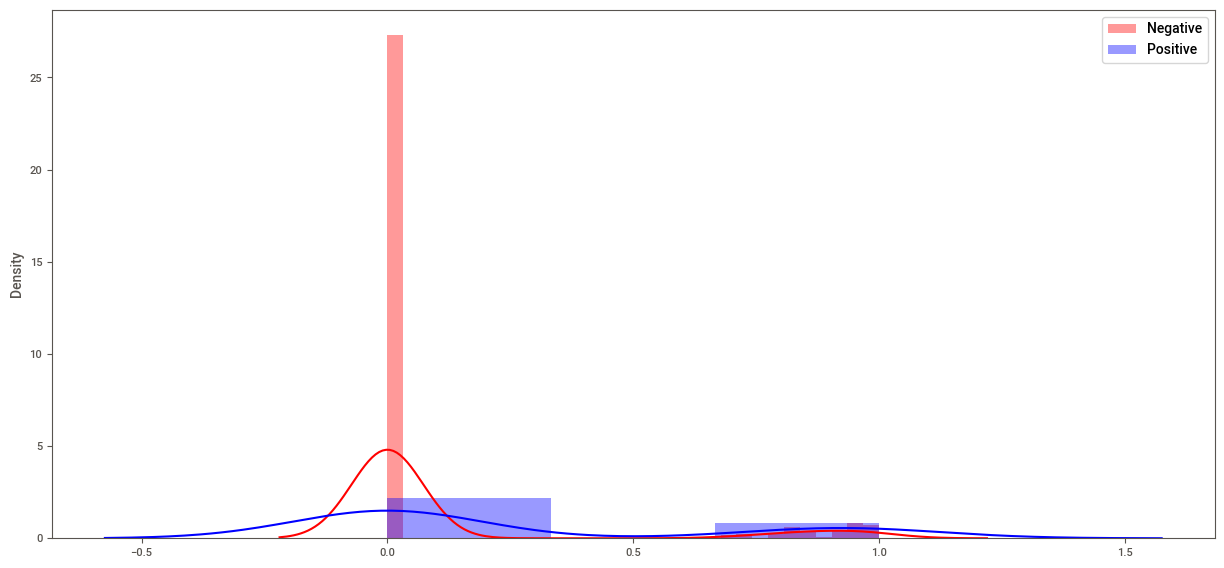

In [128]:
y_scores = model_sin_poda.predict_proba(x_test)
out_probs = y_scores[:, 1]

plt.figure(figsize=(15, 7))
sns.distplot(out_probs[y_test == 0], color="r", label="Negative")
sns.distplot(out_probs[y_test == 1], color="b", label="Positive")
plt.legend()

(0.0, 1.0)

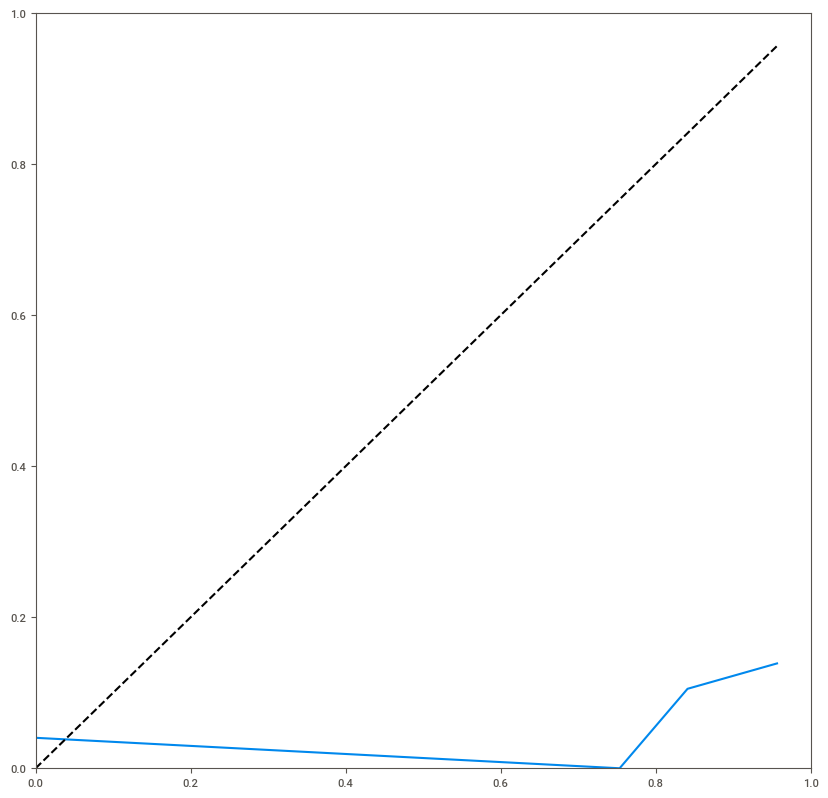

In [129]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,out_probs,n_bins=10)
plt.figure(figsize=(10,10))
plt.plot(mean_predicted_value,fraction_of_positives)
plt.plot(mean_predicted_value,mean_predicted_value,'k--')
plt.ylim(0,1)
plt.xlim(0,1)

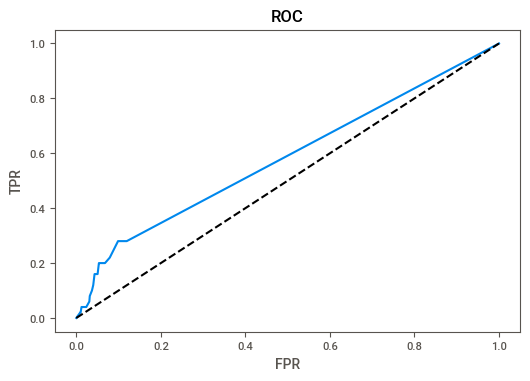

In [130]:
fpr, tpr, th = roc_curve(y_test, out_probs)

plt.title("ROC")
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr, fpr, "--k")

In [131]:
fig = plt.figure(figsize=(200, 100))
featnames = data.columns
plot_tree(
    model_sin_poda, feature_names=featnames, filled=True, proportion=False, impurity=True
)

# Guarda la imágen con la hora para no pisar un caso previo
# fig.savefig(
#     "{0}.decistion_tree.png".format(datetime.datetime.now().strftime("%Y-%m-%d.%H:%M"))
# )

# Que es value? Tiene que ver con el rango, pero al estar desbalanceado
#    pondera por el peso y ajusta el rango así (O algo así nos comentó leo)

[Text(5077.874661880982, 7361.25, 'age <= 47.5\ngini = 0.5\nsamples = 4088\nvalue = [2044.0, 2044.0]'),
 Text(864.3362463587183, 6983.75, 'age <= 37.5\ngini = 0.111\nsamples = 2191\nvalue = [1147.878, 71.899]'),
 Text(412.8173116937162, 6606.25, 'age <= 1.36\ngini = 0.024\nsamples = 1601\nvalue = [840.936, 10.271]'),
 Text(309.61298377028714, 6228.75, 'age <= 1.28\ngini = 0.377\nsamples = 59\nvalue = [30.484, 10.271]'),
 Text(206.4086558468581, 5851.25, 'age <= 0.28\ngini = 0.0\nsamples = 51\nvalue = [26.805, 0.0]'),
 Text(103.20432792342905, 5473.75, 'gini = 0.0\nsamples = 6\nvalue = [3.154, 0.0]'),
 Text(309.61298377028714, 5473.75, 'gini = 0.0\nsamples = 45\nvalue = [23.651, 0.0]'),
 Text(412.8173116937162, 5851.25, 'gini = 0.388\nsamples = 8\nvalue = [3.679, 10.271]'),
 Text(516.0216396171452, 6228.75, 'gini = 0.0\nsamples = 1542\nvalue = [810.452, 0.0]'),
 Text(1315.8551810237204, 6606.25, 'bmi_inputation_knn <= 45.7\ngini = 0.279\nsamples = 590\nvalue = [306.942, 61.628]'),
 Text

In [132]:
importancia_predictores = pd.DataFrame(
    {"Predictor": data.columns, "Importancia": model_sin_poda.feature_importances_}
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("Importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


Predictor  Importancia
0                              age     0.543860
3                avg_glucose_level     0.182822
18              bmi_inputation_knn     0.161202
11               work_type_Private     0.016138
5              resident_type_urban     0.014917
14          smoking_status_Unknown     0.013120
16     smoking_status_never_smoked     0.012411
7                      gender_Male     0.010277
9               work_type_Govt_job     0.008916
4                 ever_married_cat     0.006701
15  smoking_status_formerly_smoked     0.006331
1                     hypertension     0.006191
12         work_type_Self-employed     0.005432
17           smoking_status_smokes     0.005228
2                    heart_disease     0.003926
6                    gender_Female     0.002529
8                     gender_Other     0.000000
10          work_type_Never_worked     0.000000
13              work_type_children     0.000000

La gráfica muestra como overfittea, y termina casi todas las variables, absurdamente específico

## Descriptores

k) Para el árbol sin poda, obtener la importancia de los descriptores usando la técnica de eliminación recursiva. Reentrenar el árbol usando sólo los 3 descriptores más importantes. Comparar la performance en el conjunto de prueba.

**ref**: https://towardsdatascience.com/feature-selection-techniques-1bfab5fe0784

_Recursive Feature Elimination (RFE)_ takes as input the instance of a Machine Learning model and the final desired number of features to use. It then recursively reduces the number of features to use by ranking them using the Machine Learning model accuracy as metrics.

In [133]:
from time import process_time

rfe = RFE(best_model, n_features_to_select=3, verbose=10, step=1)
start = time.process_time()
RFE_X_Train = rfe.fit_transform(x_train, y_train)
RFE_X_Test = rfe.transform(x_test)
rfe = rfe.fit(RFE_X_Train, y_train)
print(f"Tiempo: {time.process_time() - start} segundos")
# print(f"Tiempo: {round(time.process_time() - start, 2)} segundos")
print("Overall Accuracy using RFE: ", rfe.score(RFE_X_Test, y_test))

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Tiempo: 0.14518852599999832 segundos
Overall Accuracy using RFE:  0.6917808219178082


In [134]:
# TBD: Usar predict con test y usar despues la métrica que nos interesa
y_pred_test = rfe.predict(RFE_X_Test)
y_pred_train = rfe.predict(RFE_X_Train)

print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))
print("Test recall: {}".format(recall_score(y_test, y_pred_test)))
print("Test F1: {}".format(fbeta_score(y_test, y_pred_test, beta=1)))
print("Test F2: {}".format(fbeta_score(y_test, y_pred_test, beta=2)))

print(classification_report(y_test, y_pred_test))
predictions = rfe.predict(RFE_X_Test)

Train acc: 0.6942270058708415
Test acc: 0.6917808219178082
Test recall: 0.78
Test F1: 0.1984732824427481
Test F2: 0.3591160220994475
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       972
           1       0.11      0.78      0.20        50

    accuracy                           0.69      1022
   macro avg       0.55      0.73      0.50      1022
weighted avg       0.94      0.69      0.78      1022



## Fin

**Atención**: los puntos anteriores no necesariamente deben ser respondidos en el mismo orden en el que son formulados. El único requisito es que sus respuestas estén en alguna parte del informe entregado.